MOVE STUFF HERE FROM skillcornerSmooth.ipynb

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from mplsoccer.pitch import Pitch
import json
import pandas as pd
import re
from math import isnan, sqrt
from datetime import datetime, timedelta
from smoothingWithCurvatureSigns import performSmoothing, euclidianDistance
from scipy.signal import savgol_filter

In [126]:
import csv

def read_csv_partially(file_path, start_line, end_line):
    data = []  # List to store extracted CSV rows

    with open(file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        for line_num, row in enumerate(reader):
            if line_num >= start_line and line_num <= end_line:
                # Append the row to data
                data.append(row)
            elif line_num > end_line:
                break  # Stop reading once end_line is reached

    return data

In [127]:
def plotMovement(playerID, df, start_frame=34591, end_frame=34764):

    pitch = Pitch(pitch_type='skillcorner', axis=True, label=True,
                  pitch_length=105, pitch_width=68,
                  pitch_color='white', line_color='black',)

    df = df[df['object_id'] == playerID].copy().reset_index()

    fig, ax = pitch.draw(figsize=(20, 16), constrained_layout=True, tight_layout=False)
    window = [60,-60,60,-60]
    for i, frame in df.iterrows():
        # for i in range(1, len(frame)):
        if frame['frame_id'] >= start_frame and frame['frame_id'] <= end_frame:
            x = float(frame['x'])
            y = float(frame['y'])
            window = [min(x, window[0]), max(x, window[1]), min(y, window[2]), max(y, window[3])]

            if isnan(x) or isnan(y):
                continue
            ax.plot(x, y, 'ro', markersize=5, color='blue')
            if i > 1:
                x_prev = float(df.loc[i-1, 'x'])
                y_prev = float(df.loc[i-1, 'y'])
                if isnan(x_prev) or isnan(y_prev):
                    continue
                ax.plot([x_prev, x], [y_prev, y], 'r-', linewidth=2)
                ax.arrow(x_prev, y_prev, x - x_prev, y - y_prev, color='r', head_width=0.2, head_length=0.4)
    
    ax.set_xlim([window[0]-5, window[1]+5])
    ax.set_ylim([window[2]-5, window[3]+5])
    plt.show()

In [128]:
def plotMovements(playerID, dfs, start_frame, end_frame, labels, windowp=None):
    pitch = Pitch(pitch_type='skillcorner', axis=True, label=True,
                pitch_length=105, pitch_width=68,
                pitch_color='white', line_color='black',)
    
    fig, ax = pitch.draw(figsize=(20, 16), constrained_layout=True, tight_layout=False)
    for index, DF in enumerate(dfs):
        df = DF[DF['object_id'] == playerID].copy().reset_index()
        # add a label for each index in the legend

        window = [60,-60,60,-60]
        for i, frame in df.iterrows():
            # for i in range(1, len(frame)):
            if frame['frame_id'] >= start_frame and frame['frame_id'] <= end_frame:
                x = float(frame['x'])
                y = float(frame['y'])
                window = [min(x, window[0]), max(x, window[1]), min(y, window[2]), max(y, window[3])]

                if isnan(x) or isnan(y):
                    continue
               
                if index != 0:
                    if i != 0:
                        ax.plot(x, y, 'ro', markersize=10, marker='o', markerfacecolor='none', markeredgecolor='blue', markeredgewidth=1, color='blue')
                    else:
                        ax.plot(x, y, 'ro', markersize=10, marker='o', markerfacecolor='none', markeredgecolor='blue', markeredgewidth=1, color='blue', label=labels[index])                    
                else:
                    y_prev = float(dfs[1].loc[i, 'y'])
                    x_prev = float(dfs[1].loc[i, 'x'])
                    if i != 0:
                        ax.plot([x_prev, x], [y_prev, y], 'b-', linewidth=0.5, color='red') # Add red lines between the points
                        ax.plot(x, y, 'ro', markersize=10, marker='o', color='orange')
                    else:
                        ax.plot([x_prev, x], [y_prev, y], 'b-', linewidth=0.5, color='red', label='Corresponding points') # Add red lines between the points
                        ax.plot(x, y, 'ro', markersize=10, marker='o', color='orange', label=labels[index])
                    # x_prev = float(df.loc[i-1, 'x'])
                    # y_prev = float(df.loc[i-1, 'y'])
                    # label = labels[index] if labels != [] else 'DF '+str(index+1)
                    # if isnan(x_prev) or isnan(y_prev):
                    #     continue
                    # if i == 2:
                    #     ax.plot([x_prev, x], [y_prev, y], colors[(index*3)%11], linewidth=2, label=label)
                    # else:
                    #     ax.plot([x_prev, x], [y_prev, y], colors[(index*3)%11], linewidth=2)
                    # ax.arrow(x_prev, y_prev, x - x_prev, y - y_prev, color=colors[(index*3)%11], head_width=0.2, head_length=0.4)
    if windowp:
        ax.set_xlim([windowp[0], windowp[1]])
        ax.set_ylim([windowp[2], windowp[3]])
    else:
        ax.set_xlim([window[0]-5, window[1]+5])
        ax.set_ylim([window[2]-5, window[3]+5])
    ax.legend()
    plt.show()

In [129]:
def plotMovementLines(playerID, dfs, start_frame, end_frame, labels, windowp=None,  save=""):
    pitch = Pitch(pitch_type='skillcorner', axis=True, label=True,
                pitch_length=105, pitch_width=68,
                pitch_color='white', line_color='black',)
    
    fig, ax = pitch.draw(figsize=(20, 16), constrained_layout=True, tight_layout=False)
    for index, DF in enumerate(dfs):
        df = DF[DF['object_id'] == playerID].copy().reset_index()
        # add a label for each index in the legend

        window = [60,-60,60,-60]
        for i, frame in df.iterrows():
            # for i in range(1, len(frame)):
            if frame['frame_id'] >= start_frame and frame['frame_id'] <= end_frame:
                x = float(frame['x'])
                y = float(frame['y'])
                window = [min(x, window[0]), max(x, window[1]), min(y, window[2]), max(y, window[3])]

                if isnan(x) or isnan(y):
                    continue
               
                color = 'blue' if index == 0 else 'orange'
                lw = 4 if index == 0 else 3
                if(i > 0):
                    x_prev = float(df.loc[i-1, 'x'])
                    y_prev = float(df.loc[i-1, 'y'])
                    if isnan(x_prev) or isnan(y_prev):
                        continue
                    if(i == 1):
                        ax.plot([x_prev, x], [y_prev, y], 'b-', linewidth=lw, color=color, label=labels[index])
                    else:
                        ax.plot([x_prev, x], [y_prev, y], 'b-', linewidth=lw, color=color)


                # if index != 0:
                #     if i != 0:
                #         ax.plot(x, y, 'ro', markersize=10, marker='o', markeredgecolor='blue', markeredgewidth=1, color='blue')
                #     else:
                #         ax.plot(x, y, 'ro', markersize=10, marker='o', markeredgecolor='blue', markeredgewidth=1, color='blue', label=labels[index])                    
                # else:
                #     if i != 0:
                #         ax.plot(x, y, 'ro', markersize=10, marker='o', markeredgecolor='orange', markeredgewidth=1, color='blue')
                #     else:
                #         ax.plot(x, y, 'ro', markersize=10, marker='o', markeredgecolor='orange', markeredgewidth=1, color='blue', label=labels[index])

    if windowp:
        ax.set_xlim([windowp[0], windowp[1]])
        ax.set_ylim([windowp[2], windowp[3]])
    else:
        ax.set_xlim([window[0]-5, window[1]+5])
        ax.set_ylim([window[2]-5, window[3]+5])
    ax.legend()
    if(save != ""):
        plt.savefig(save, format='png')
        plt.clf()
    else:
        plt.show()

In [130]:
match_id = 1384039

file_path_skillcorner = '../data/matches/Feb/1384039_tracking.csv'
lineup_path = '../data/matches/Feb/1384039_lineup.csv'
partialframes = read_csv_partially(file_path_skillcorner, 0, 1500000)

lineup = read_csv_partially(lineup_path, 0, 33)
# targetIDSkillcorner = 7679
targetIDSkillcorner = 10218
targetPositionsSkillcorner = []

def getTrajectories(teamName, lineup, partialframes):
    playerIDs = set()
    teamName = "FC Basel"

    for player in list(filter(lambda player: player[1] == teamName, lineup[1:])):
        playerIDs.add(str(player[2]))

    targetTrajs = {}
    for ID in playerIDs:
        targetTrajs[ID] = []

    for index, playerFrame in enumerate(partialframes):

        if(playerFrame[4] not in playerIDs or playerFrame[8] == 'True'):
            continue

        # defining datapoints d_i = [x_Coordinate, y_Coordinate, speed, time]
        if targetTrajs[playerFrame[4]] == [] or int(targetTrajs[playerFrame[4]][-1][-1][-1]) != (int(playerFrame[2]) - 1):
            targetTrajs[playerFrame[4]].append([])
            
        targetTrajs[playerFrame[4]][-1].append([float(playerFrame[5]), float(playerFrame[6]), 0, datetime.fromtimestamp(int(playerFrame[3])/1000.0), int(playerFrame[2])])
    return targetTrajs

targetTrajs = getTrajectories("FC Basel", lineup, partialframes)

<h1>Time Series Analysis<h1>

<h3>Speed Smoothing</h3>

In [131]:
isolatedTraj = []
playerID = -1
for player, trajs in targetTrajs.items():
    for traj in trajs:
        if len(traj) >= 590 and len(traj) <= 590:
            print(player)
            print(len(traj))
            playerID = player
            isolatedTraj = traj
            break
    if playerID != -1:
        break

start_frame = isolatedTraj[0][-1]
end_frame = isolatedTraj[-1][-1]

sparseTraj = []
for i, frame in enumerate(isolatedTraj):
    if i % 20 == 0:
        sparseTraj.append(frame)

smoothSparseTrajs = []
smoothIsolatedTrajs = []

# its = [
#     0,
#     50,
#     100,
#     600,
# ]
its = [
    0, 
    # 1, 
    # 2, 
    # 5, 
    # 6, 
    # 12, 
    # 15, 
    # 20, 
    # 30, 
    # 40, 
    # 50, 
    # 60, 
    # 70, 
    # 80, 
    # 90, 
    # 100, 
    # 110, 
    # 120,
    # 600,
    # 10000,
    20000,
]

# its = [
#     0, 
#     100, 
#     # 200, 
#     # 300, 
#     # 400, 
#     # 500, 
#     # 600, 
#     # 700, 
#     # 800, 
#     # 900, 
#     # 1000, 
#     # 1100, 
#     # 1200, 
#     # 1300, 
#     # 1400, 
#     # 1500, 
#     # 1600, 
#     # 1700, 
#     # 1800,
#     # 1900,
#     20000,
# ]

for it in its:
    print(f'Performing smoothing with it={it}')
    smoothIsolatedTrajs.append([])
    smoothSparseTrajs.append(performSmoothing(sparseTraj, it))

isolatedTraj = pd.DataFrame(isolatedTraj)
isolatedTraj.columns = ['x', 'y', 'speed', 'time', 'frame_id']
isolatedTraj['object_id'] = playerID
isolatedTraj.columns = ['x', 'y', 'speed', 'time', 'frame_id', 'object_id']

sparseTraj = pd.DataFrame(sparseTraj)
sparseTraj.columns = ['x', 'y', 'speed', 'time', 'frame_id']
sparseTraj['object_id'] = playerID
sparseTraj.columns = ['x', 'y', 'speed', 'time', 'frame_id', 'object_id']

102835
590
Performing smoothing with it=0
Performing smoothing with it=20000


In [134]:
# sTraj = pd.DataFrame(smoothIsolatedTrajs[-1])
# sTraj.columns = ['x', 'y', 'speed', 'time', 'frame_id']
# sTraj['object_id'] = playerID
# sTraj['frame_id'] = isolatedTraj['frame_id']
# sTraj

ssparseTraj = pd.DataFrame(smoothSparseTrajs[-1])
ssparseTraj.columns = ['x', 'y', 'speed', 'time', 'frame_id']
ssparseTraj['object_id'] = playerID
ssparseTraj['frame_id'] = sparseTraj['frame_id']
ssparseTraj

,x,y,speed,time,frame_id,object_id
0,35.470000,2.740000,0.000000,1970-01-01 01:13:19.200,38192,102835
1,34.960622,3.180933,0.676105,1970-01-01 01:13:21.200,38212,102835
2,34.613310,3.757833,0.675811,1970-01-01 01:13:23.200,38232,102835
3,34.439713,4.408884,0.675604,1970-01-01 01:13:25.200,38252,102835
4,34.425339,5.082889,0.675395,1970-01-01 01:13:27.200,38272,102835
5,34.543656,5.746828,0.675175,1970-01-01 01:13:29.200,38292,102835
6,34.764748,6.384084,0.674940,1970-01-01 01:13:31.200,38312,102835
7,35.060196,6.990466,0.674694,1970-01-01 01:13:33.200,38332,102835
8,35.405157,7.570012,0.674439,1970-01-01 01:13:35.200,38352,102835
9,35.778650,8.131395,0.674182,1970-01-01 01:13:37.200,38372,102835


KeyError: 'object_id'

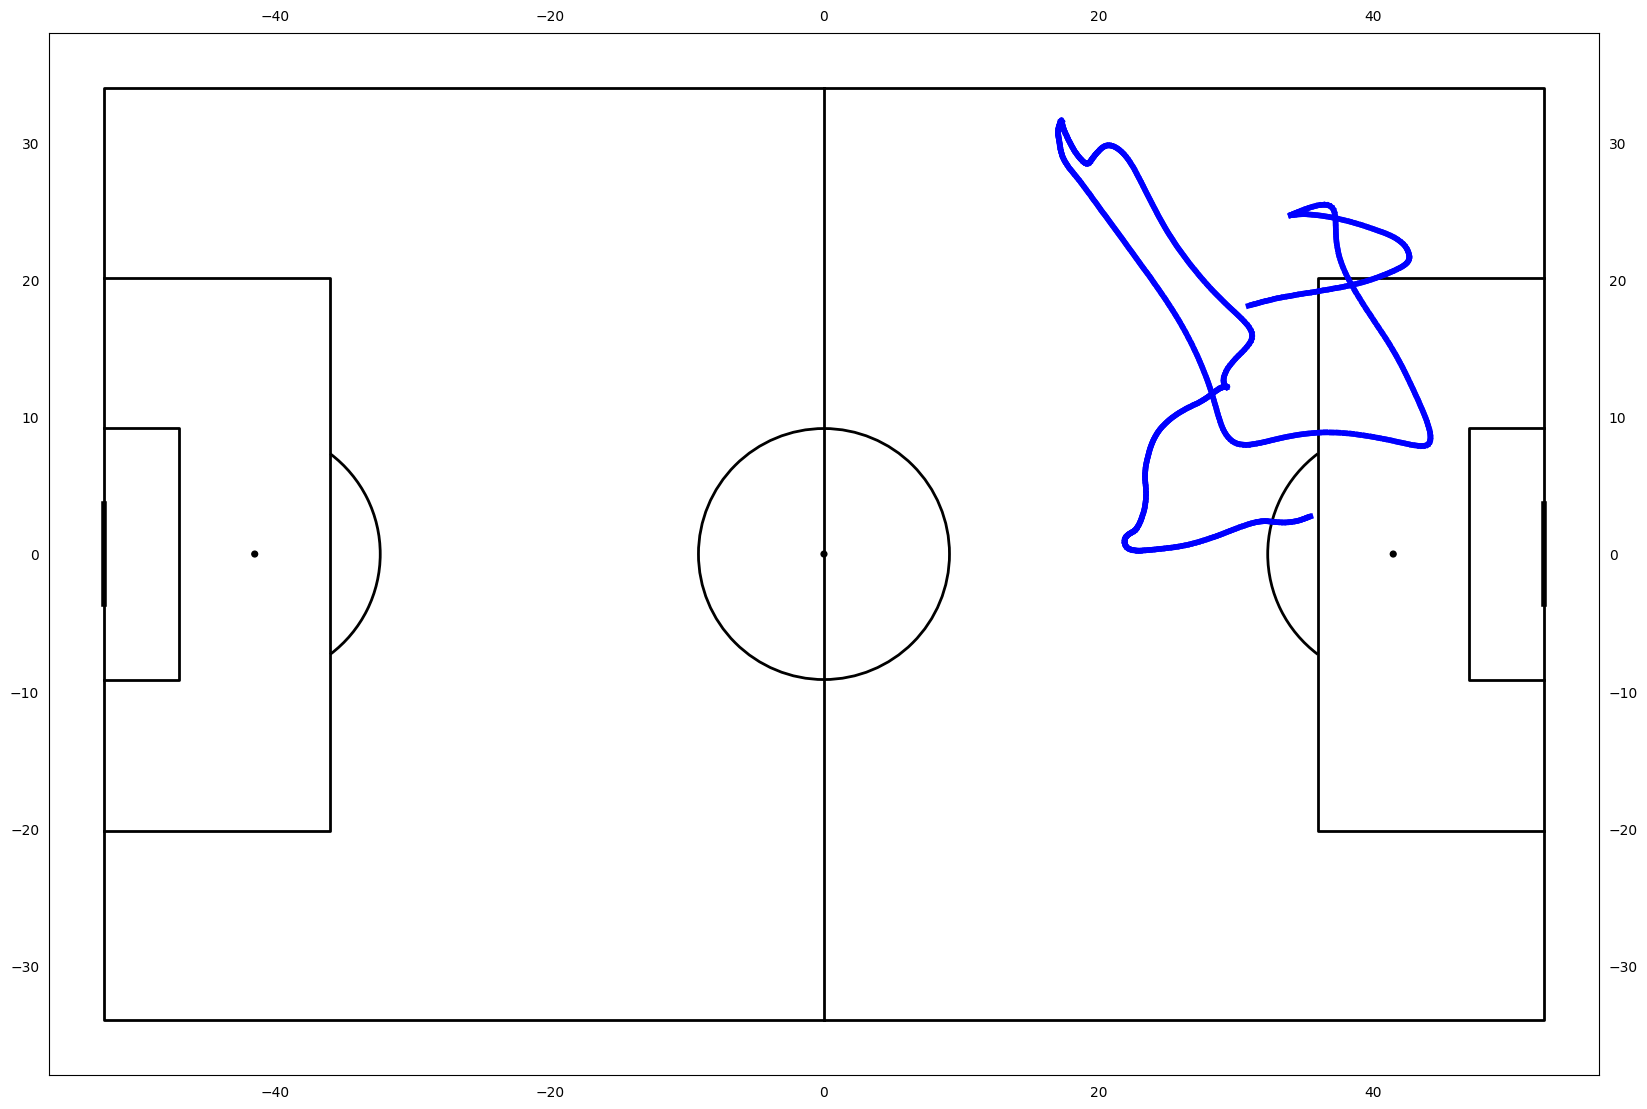

In [133]:
plotMovementLines(playerID, [isolatedTraj, sTraj], start_frame, end_frame, ['Original', 'Smoothed'])


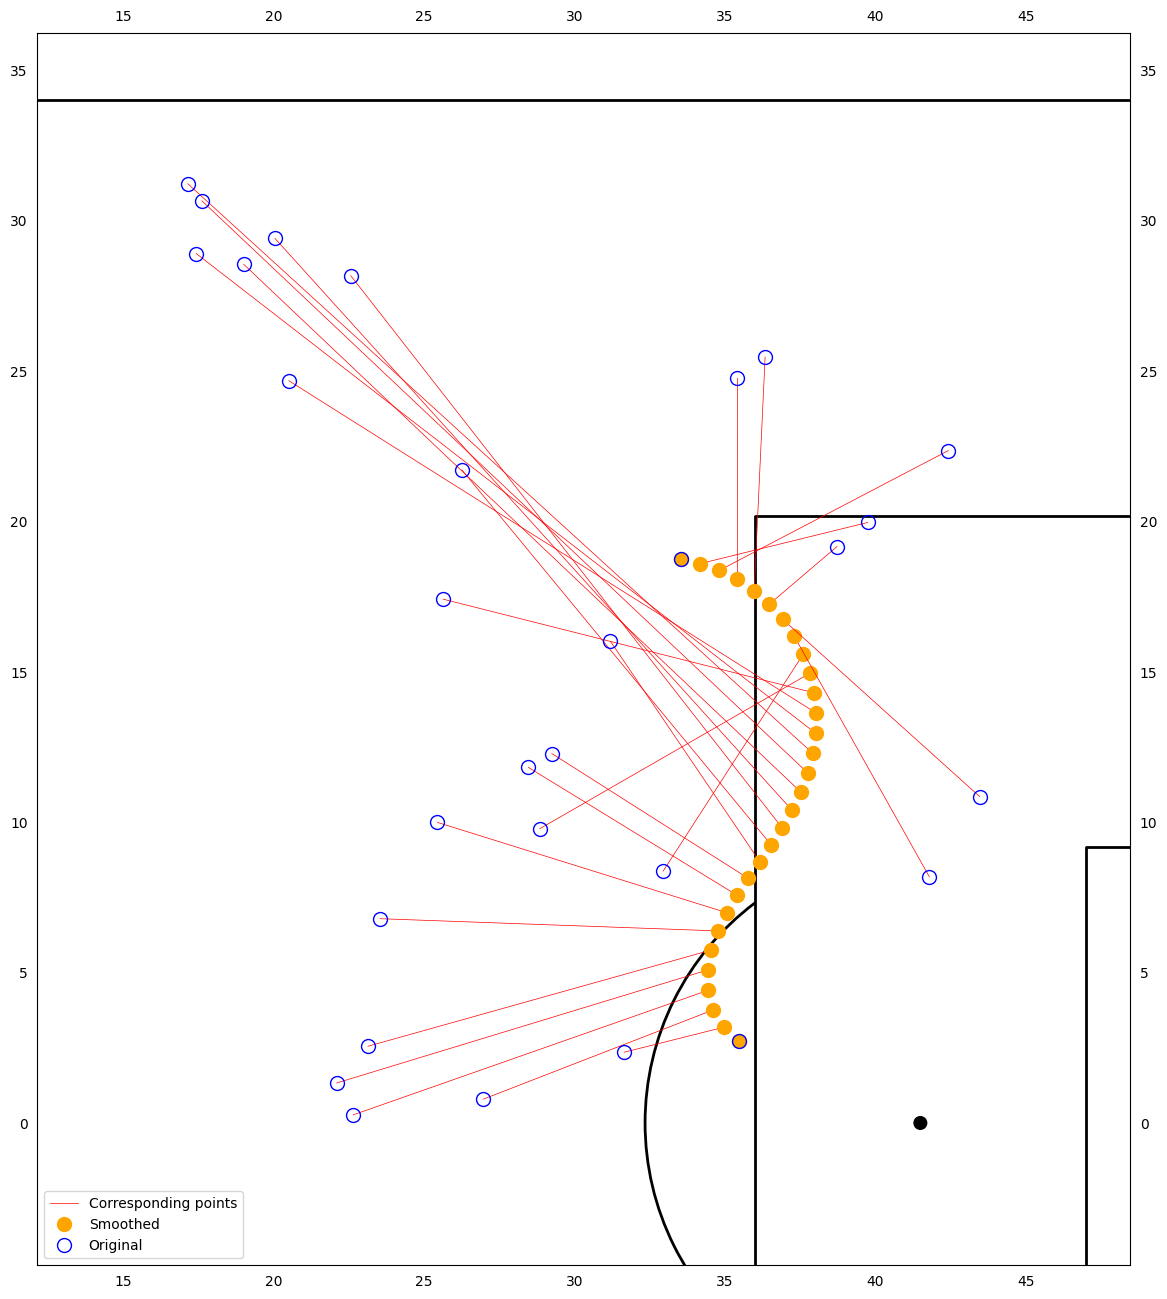

In [135]:
plotMovements(playerID, [ssparseTraj, sparseTraj], start_frame, end_frame, ['Smoothed', 'Original'])

**Add Gaussian Filtering on Frecquency Domain of Speed signal**

In [ ]:
def extractSpeed(df):
    euclidean_distance1 = np.sqrt((df['x'] - df['x'].shift(1))**2 + (df['y'] - df['y'].shift(1))**2)
    euclidean_distance2 = np.sqrt((df['x'] - df['x'].shift(-1))**2 + (df['y'] - df['y'].shift(-1))**2)
    df['speed'] = (euclidean_distance1+euclidean_distance2)/(df['frame_id'].shift(-1)-df['frame_id'].shift(1))*10
    return df

<h2>DIFFERENCE in scaling cause by high variations of acceleration between nearby points that get removed</h2>
How to counter act?

Average out point locations? -> this would lead to a sort of smoothing which we don t want 

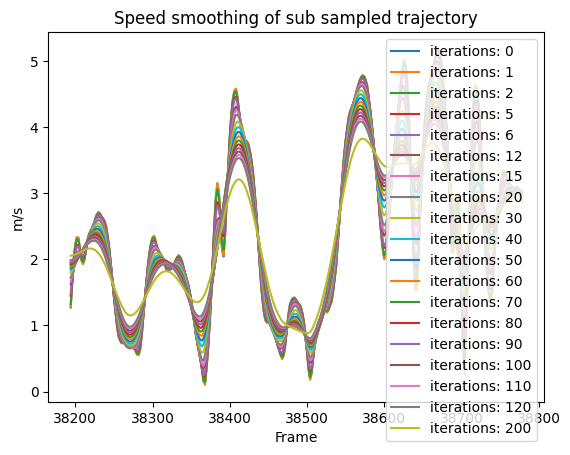

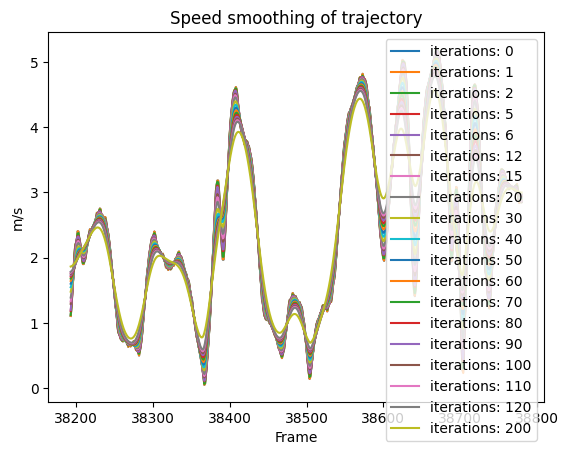

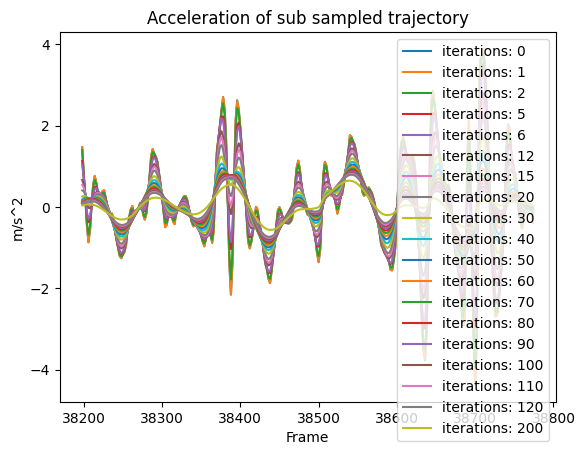

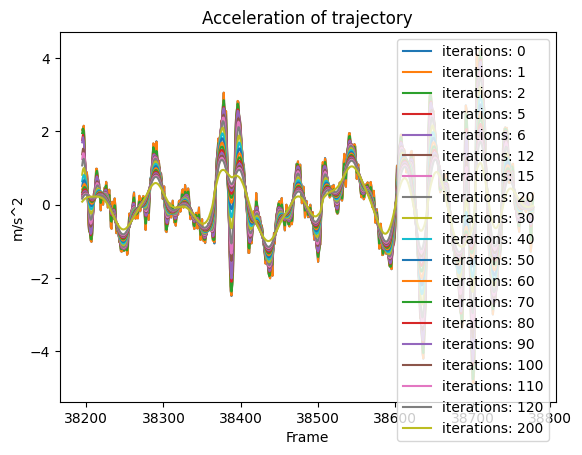

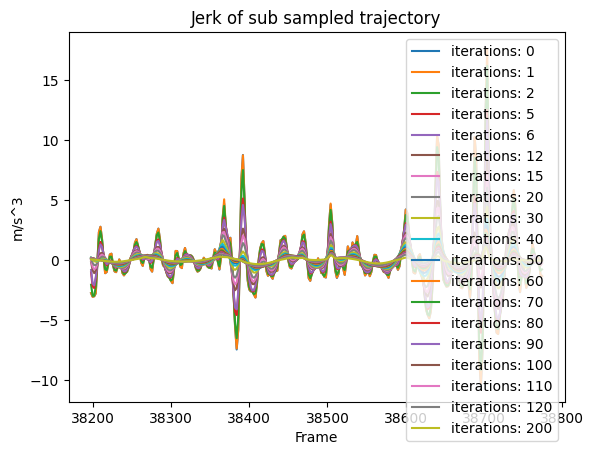

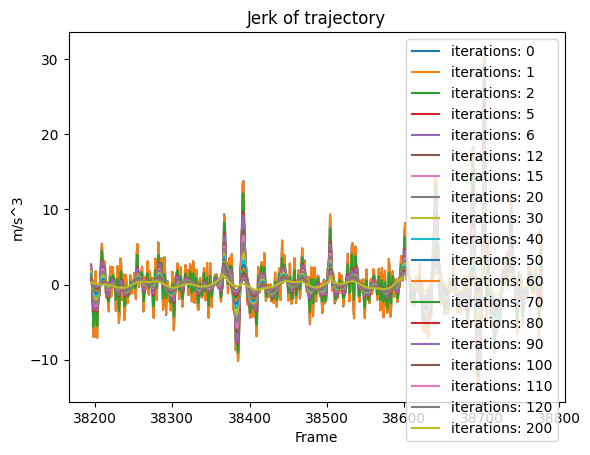

    iterations       std man_std      mean
0            0  4.046299     NaN -0.031843
1            1  5.136582     NaN -0.193173
2            2  4.761211     NaN -0.191849
3            5  4.364089     NaN -0.190471
4            6  4.293268     NaN -0.190545
5           12  4.038695     NaN -0.191834
6           15  3.962686     NaN -0.192523
7           20  3.872633     NaN -0.193596
8           30   3.76875     NaN -0.195511
9           40  3.715736     NaN -0.197162
10          50  3.687046     NaN -0.198585
11          60  3.671139     NaN -0.199817
12          70  3.662401     NaN -0.200892
13          80  3.657889     NaN  -0.20184
14          90   3.65597     NaN -0.202684
15         100  3.655703     NaN -0.203442
16         110  3.656522     NaN -0.204129
17         120  3.658077     NaN -0.204758
18         200  3.680424     NaN -0.208448
    iterations       std      mean
0            0  2.785318 -0.036814
1            1  3.015609 -0.119065
2            2  2.788764 -0.116246


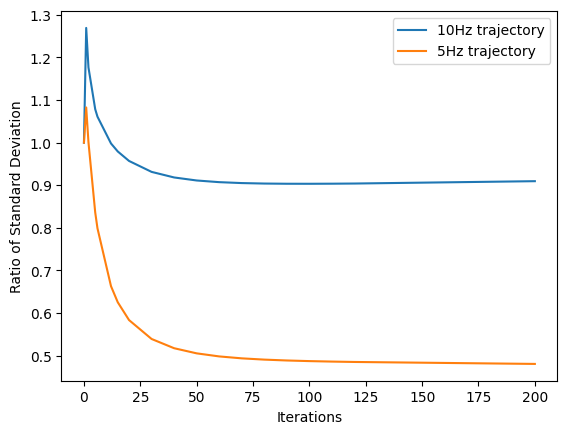

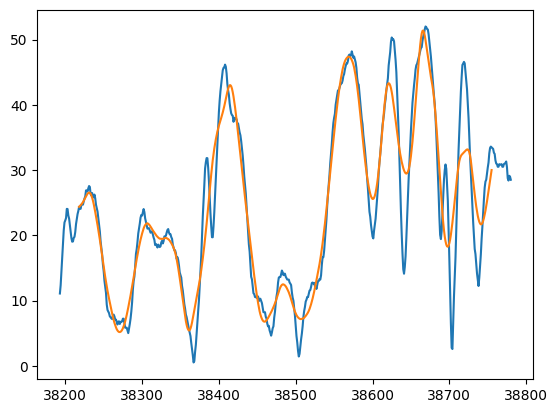

In [ ]:
# plot the speed timeseries 
smoothSparseTrajsDFs = []
for i, traj in enumerate(smoothSparseTrajs):
    traj = pd.DataFrame(traj)
    traj.columns = ['x', 'y', 'speed', 'time', 'frame_id']
    traj['frame_id'] = sparseTraj[4]
    traj['frame_id'] = traj['frame_id'].astype(int)
    traj['object_id'] = playerID

    if(i == 0): # NO SMOOTHING
        traj = extractSpeed(traj)
        # smoothSparseTrajs[i] = traj.values.tolist()
    else:
        traj['speed'] = traj['speed']*5

    traj['acceleration'] = (traj['speed'].shift(-1) - traj['speed'].shift(1))/(traj['frame_id'].shift(-1) - traj['frame_id'].shift(1))*10
    traj['jerk'] = (traj['acceleration'].shift(-1) - traj['acceleration'].shift(1))/(traj['frame_id'].shift(-1) - traj['frame_id'].shift(1))*10

    smoothSparseTrajsDFs.append(traj)
    plt.plot(traj.loc[:, 'frame_id'][1:-1], (traj.loc[:, 'speed'][1:-1]), color='C'+str(i), label='iterations: ' + str(its[i]))

plt.title('Speed smoothing of sub sampled trajectory')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s')  # Replace 'Value' with the actual y-axis label
plt.legend()
plt.show()

smoothIsolatedTrajsDFs = []
for i, traj in enumerate(smoothIsolatedTrajs):
    traj = pd.DataFrame(traj)
    traj.columns = ['x', 'y', 'speed', 'time', 'frame_id']
    traj['frame_id'] = isolatedTraj['frame_id']
    traj['frame_id'] = traj['frame_id'].astype(int)
    traj['object_id'] = playerID

    if(i == 0): # NO SMOOTHING
        traj = extractSpeed(traj)
    # speed approximation on circle arc
    else:
        traj['speed'] = traj['speed']*10
    
    traj['acceleration'] = (traj['speed'].shift(-1) - traj['speed'].shift(1))/(traj['frame_id'].shift(-1) - traj['frame_id'].shift(1))*10
    traj['jerk'] = (traj['acceleration'].shift(-1) - traj['acceleration'].shift(1))/(traj['frame_id'].shift(-1) - traj['frame_id'].shift(1))*10

    smoothIsolatedTrajsDFs.append(traj)
    plt.plot(traj.loc[:, 'frame_id'][1:-1], (traj.loc[:, 'speed'][1:-1]), color='C'+str(i), label='iterations: ' + str(its[i]))

plt.title('Speed smoothing of trajectory')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s')  # Replace 'Value' with the actual y-axis label
plt.legend()
# plt.xlim(38222, 38335)
plt.show()

for i, traj in enumerate(smoothSparseTrajsDFs):
    plt.plot(traj.loc[:, 'frame_id'][3:-3], (traj.loc[:, 'acceleration'][3:-3]), color='C'+str(i), label='iterations: ' + str(its[i]))
# plt.plot(smoothIsolatedTrajsDFs[0].loc[:, 'frame_id'][1:-1], (smoothIsolatedTrajsDFs[0].loc[:, 'jerk'][1:-1]), color='C0', label='iterations: ' + str(its[0]))
plt.title('Acceleration of sub sampled trajectory')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s^2')  # Replace 'Value' with the actual y-axis label
plt.legend()
plt.show()

for i, traj in enumerate(smoothIsolatedTrajsDFs):
    plt.plot(traj.loc[:, 'frame_id'][3:-3], (traj.loc[:, 'acceleration'][3:-3]), color='C'+str(i), label='iterations: ' + str(its[i]))
# plt.plot(smoothIsolatedTrajsDFs[0].loc[:, 'frame_id'][1:-1], (smoothIsolatedTrajsDFs[0].loc[:, 'jerk'][1:-1]), color='C0', label='iterations: ' + str(its[0]))
plt.title('Acceleration of trajectory')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s^2')  # Replace 'Value' with the actual y-axis label
plt.legend()
plt.show()

for i, traj in enumerate(smoothSparseTrajsDFs):
    plt.plot(traj.loc[:, 'frame_id'][3:-3], (traj.loc[:, 'jerk'][3:-3]), color='C'+str(i), label='iterations: ' + str(its[i]))
# plt.plot(smoothIsolatedTrajsDFs[0].loc[:, 'frame_id'][1:-1], (smoothIsolatedTrajsDFs[0].loc[:, 'jerk'][1:-1]), color='C0', label='iterations: ' + str(its[0]))
plt.title('Jerk of sub sampled trajectory')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s^3')  # Replace 'Value' with the actual y-axis label
plt.legend()
plt.show()

for i, traj in enumerate(smoothIsolatedTrajsDFs):
    plt.plot(traj.loc[:, 'frame_id'][3:-3], (traj.loc[:, 'jerk'][3:-3]), color='C'+str(i), label='iterations: ' + str(its[i]))
# plt.plot(smoothIsolatedTrajsDFs[0].loc[:, 'frame_id'][1:-1], (smoothIsolatedTrajsDFs[0].loc[:, 'jerk'][1:-1]), color='C0', label='iterations: ' + str(its[0]))
plt.title('Jerk of trajectory')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s^3')  # Replace 'Value' with the actual y-axis label
plt.legend()
plt.show()

stdsSparse = pd.DataFrame(columns=['iterations', 'std', 'mean'])
stds = pd.DataFrame(columns=['iterations', 'std', 'man_std', 'mean'])
stds['iterations'] = its
stdsSparse['iterations'] = its

for i, it in enumerate(its):
    stdsSparse.loc[i, 'std'] = smoothSparseTrajsDFs[i]['jerk'].std()
    stdsSparse.loc[i, 'mean'] = smoothSparseTrajsDFs[i]['jerk'].mean()
    stds.loc[i, 'std'] = smoothIsolatedTrajsDFs[i]['jerk'].std()    
    stds.loc[i, 'mean'] = smoothIsolatedTrajsDFs[i]['jerk'].mean()

print(stds)
print(stdsSparse)
plt.plot(stds['iterations'], stds['std']/stds.loc[0, 'std'], label='10Hz trajectory')
plt.plot(stdsSparse['iterations'], stdsSparse['std']/stdsSparse.loc[0, 'std'], label='5Hz trajectory')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Ratio of Standard Deviation')
plt.show()

originalTraj = pd.DataFrame(smoothIsolatedTrajsDFs[0])
originalTraj.drop(columns=['acceleration', 'jerk'], inplace=True)
originalTraj.columns = ['x', 'y', 'speed', 'time', 'frame_id', 'object_id']
originalTraj['object_id'] = playerID
savSpeedTS = originalTraj.copy()
savSpeedTS['speed'] = savSpeedTS['speed']*10
plt.plot(savSpeedTS['frame_id'], savSpeedTS['speed'])
savSpeedTS['speed'] = savgol_filter(savSpeedTS['speed'], 51, 3)
plt.plot(savSpeedTS['frame_id'], savSpeedTS['speed'])
plt.show()

splineStds = stds

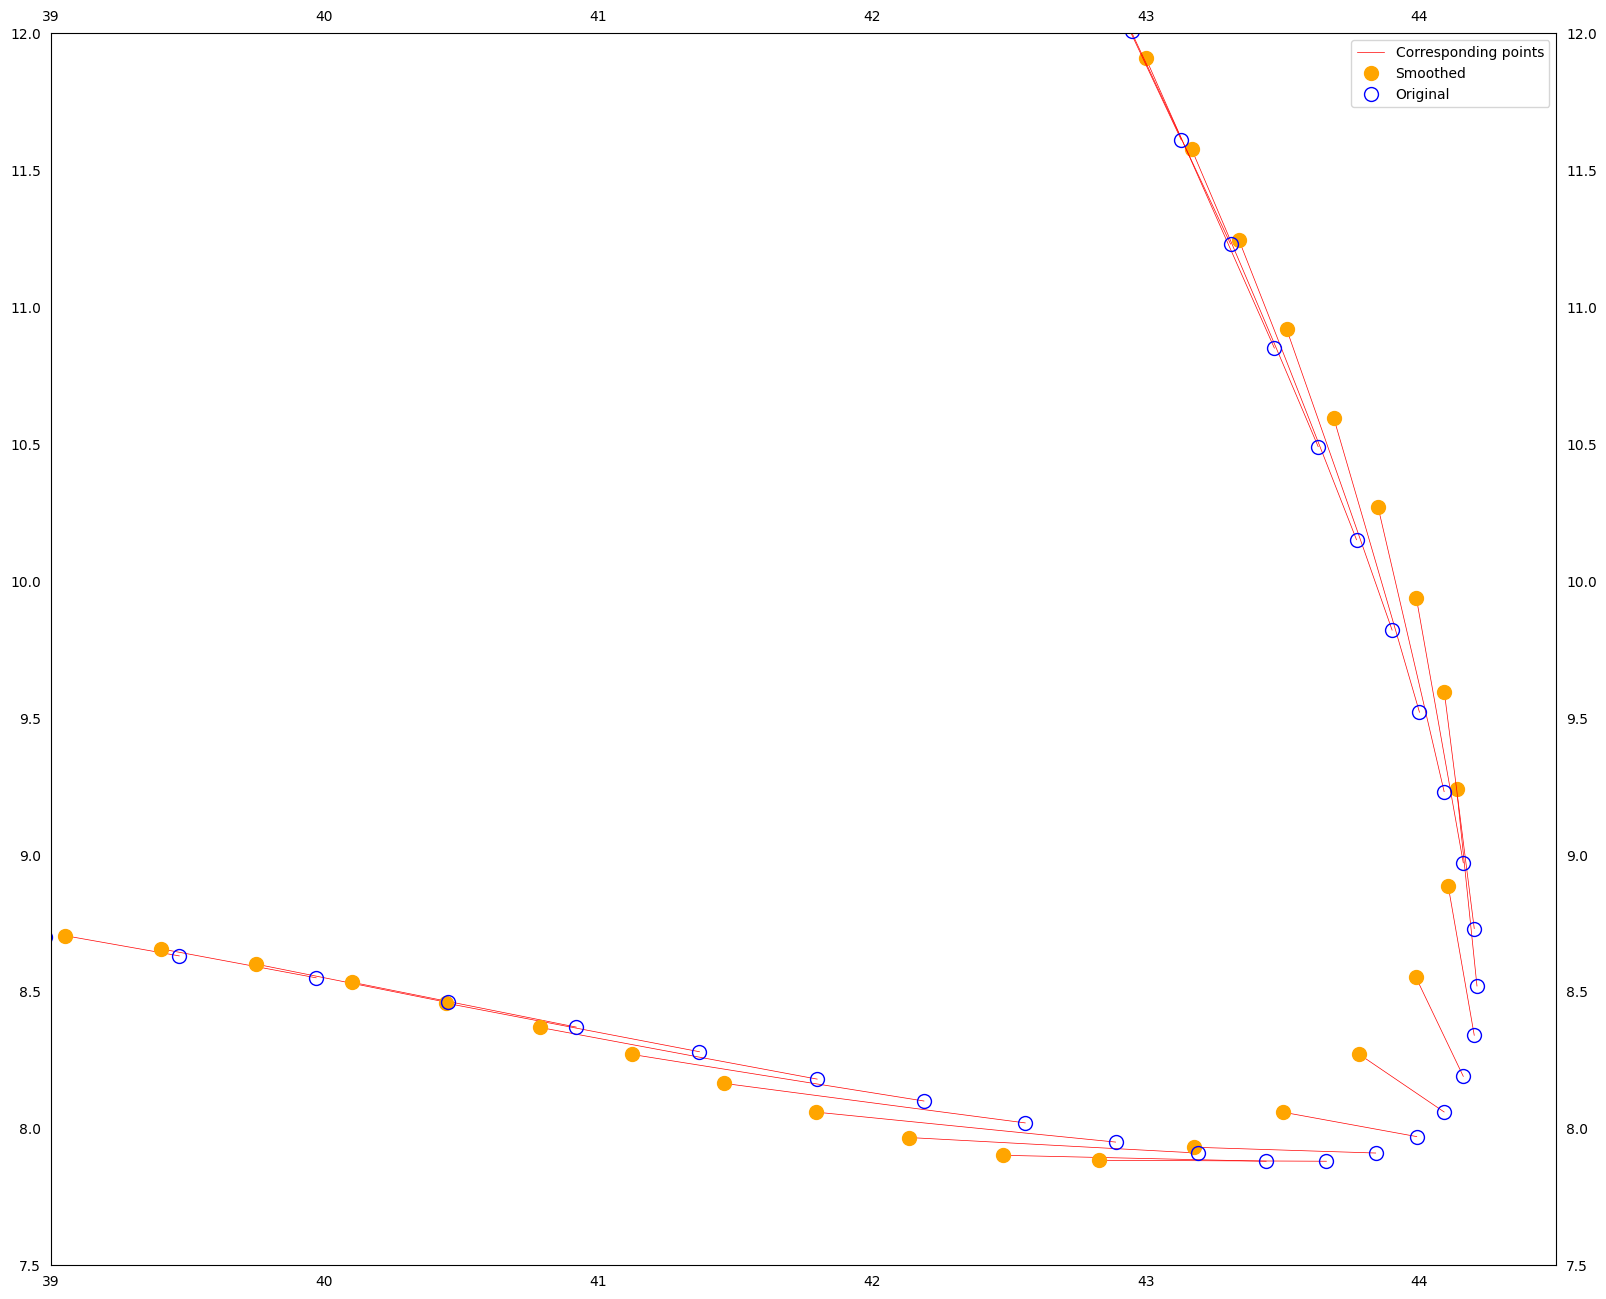

In [ ]:
plotMovements(playerID, [sTraj, isolatedTraj], start_frame, end_frame, ['Smoothed', 'Original'], windowp=[39, 44.5, 7.5, 12])

KeyboardInterrupt: 

<Figure size 2000x1600 with 0 Axes>

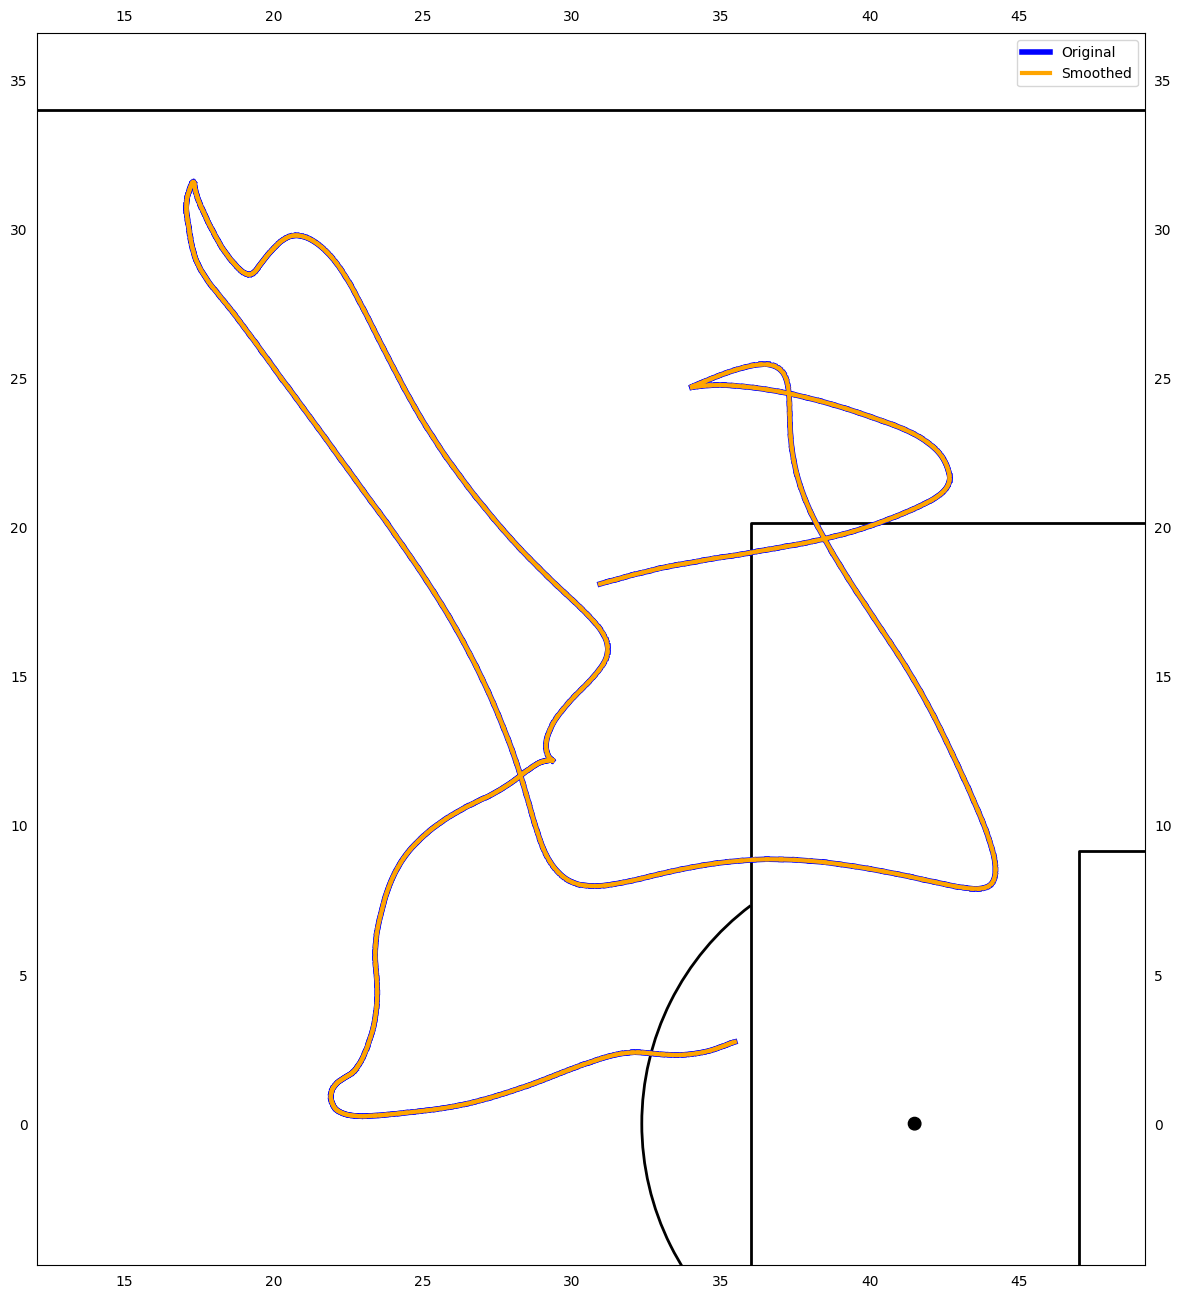

In [ ]:
for i, it in enumerate(its):
    plotMovementLines(playerID, [isolatedTraj, smoothIsolatedTrajsDFs[i]], start_frame, end_frame, ['Original', 'Smoothed'], save="images/animation/big/smoothing_it_"+str(it)+".png")

In [ ]:
savDF = originalTraj.copy()
def applySavgol(DF, window_size, polynomial_degree, iterations):
    df = DF.copy()
    for i in range(iterations):
        df['x'] = savgol_filter(df['x'], window_size, polynomial_degree)
        df['y'] = savgol_filter(df['y'], window_size, polynomial_degree)
    df = extractSpeed(df)
    df['acceleration'] = (df['speed'].shift(-1) - df['speed'].shift(1))/(df['frame_id'].shift(-1) - df['frame_id'].shift(1))*10
    df['jerk'] = (df['acceleration'].shift(-1) - df['acceleration'].shift(1))/(df['frame_id'].shift(-1) - df['frame_id'].shift(1))*10
    return df

stds = {
}
window_sizes = ['3', '5', '7', '9', '11', '13', '15', '21', '27', '33', '41', '51']
its = [str(it) for it in its]

for it in its:
    stds[it] = {} 

for key in its:
    stds[key] = {}
    for w in window_sizes:
        stds[key][w] = {}

for it in its:
    for window_size in window_sizes:
        savDF = originalTraj.copy()
        savDF = applySavgol(savDF, int(window_size), 2, int(it))
        stds[it][window_size] = savDF['jerk'].std()


def f(x, y):
    return stds[str(x)][str(y)]    

x = [int(i) for i in its]
y = [int(w) for w in window_sizes]
x, y = np.meshgrid(x, y)
z = np.array([[stds[it][window_size] for window_size in window_sizes] for it in its])

# applySavgol(7, 2, 3000)

# plotMovements(playerID, [originalTraj, savDF], start_frame, end_frame, labels=['originalTraj', 'savgol_filter'],)

# savDF = extractSpeed(savDF)
# plt.plot(originalTraj['frame_id'], originalTraj['speed']*10)
# plt.plot(savDF['frame_id'], savDF['speed']*10)
# plt.show()
# savDF

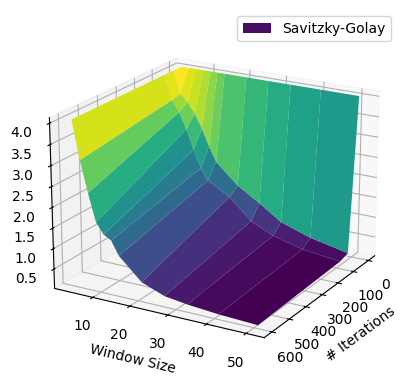

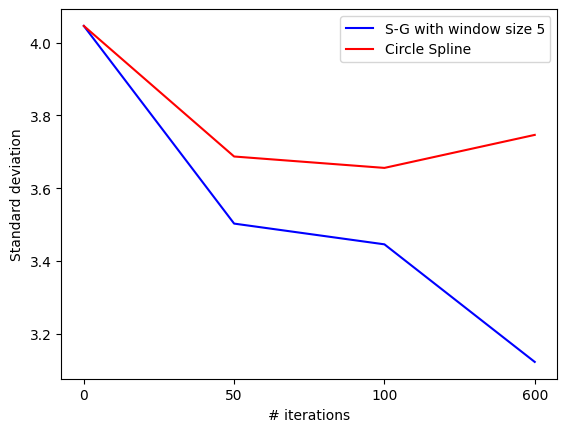

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

zprime = np.array([splineStds['std'] for _ in window_sizes])
# print(len(splineStds))
# print(len(z[0]))

ax.plot_surface(x, y, z.T, cmap='viridis', label="Savitzky-Golay")
# ax.plot_surface(x, y, zprime, color="red", alpha=0.75, label="Circle Spline Smoothing")

ax.set_xlabel('# Iterations')
ax.set_ylabel('Window Size')
ax.set_zlabel('Jerk standard deviation')
ax.legend()
ax.view_init(elev=20, azim=30)

plt.show()

sgy = np.array([stds[it]['5'] for it in its])
plt.plot(its, sgy, label="S-G with window size 5", color="blue")
plt.plot(its, np.array(splineStds['std']), label="Circle Spline", color='red')
plt.xlabel('# iterations')
plt.ylabel('Standard deviation')
plt.legend()
plt.show()

<h1>Trajectory Similarity</h1>

In [ ]:
traj1 = list(map(lambda x: [x[0], x[1]], smoothIsolatedTrajs[0]))
traj2 = list(map(lambda x: [x[0], x[1]], smoothIsolatedTrajs[0]))

<h3>Dynamic Time Warping</h3>

Using: https://dtaidistance.readthedocs.io/en/latest/

In [ ]:
import dtaidistance
from dtaidistance import dtw_ndim

series1 = np.array(traj1, dtype=np.double)
series2 = np.array(traj2, dtype=np.double)
d = dtw_ndim.distance(series1, series2)

Dmatrix = dtaidistance.dtw_ndim.distance_matrix(series1, series2)
d, paths = dtaidistance.dtw_ndim.warping_paths(series1, series2)
print(d)

def getDTWDistance(DF1, DF2):
    series1 = np.array(DF1[['x', 'y']], dtype=np.double)
    series2 = np.array(DF2[['x', 'y']], dtype=np.double)
    d = dtw_ndim.distance(series1, series2)
    return d

0.0


['0', '50', '100', '600']
0
1
2
3


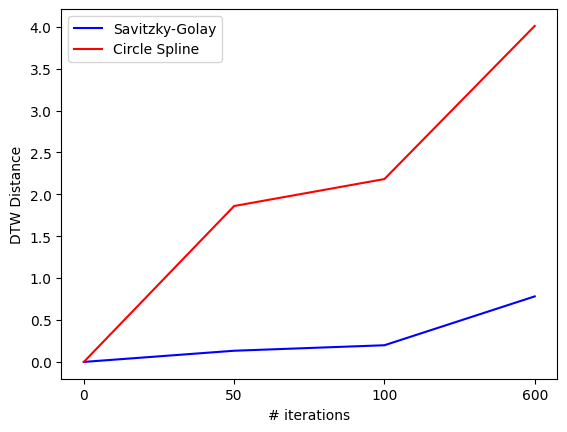

In [ ]:
print(its)
dtwSavGol = []
dtwCircleSpline = []
for i, it in enumerate(its):
    print(i)
    savDF = applySavgol(smoothIsolatedTrajsDFs[0], 5, 2, int(it))
    cSplineDF = smoothIsolatedTrajsDFs[i]
    dtwSavGol.append(getDTWDistance(savDF, smoothIsolatedTrajsDFs[0]))
    dtwCircleSpline.append(getDTWDistance(cSplineDF, smoothIsolatedTrajsDFs[0]))

plt.plot(its, dtwSavGol, color="blue", label="Savitzky-Golay")
plt.plot(its, dtwCircleSpline, color="red", label="Circle Spline")
plt.xlabel("# iterations")
plt.ylabel('DTW Distance')
plt.legend()
plt.show()

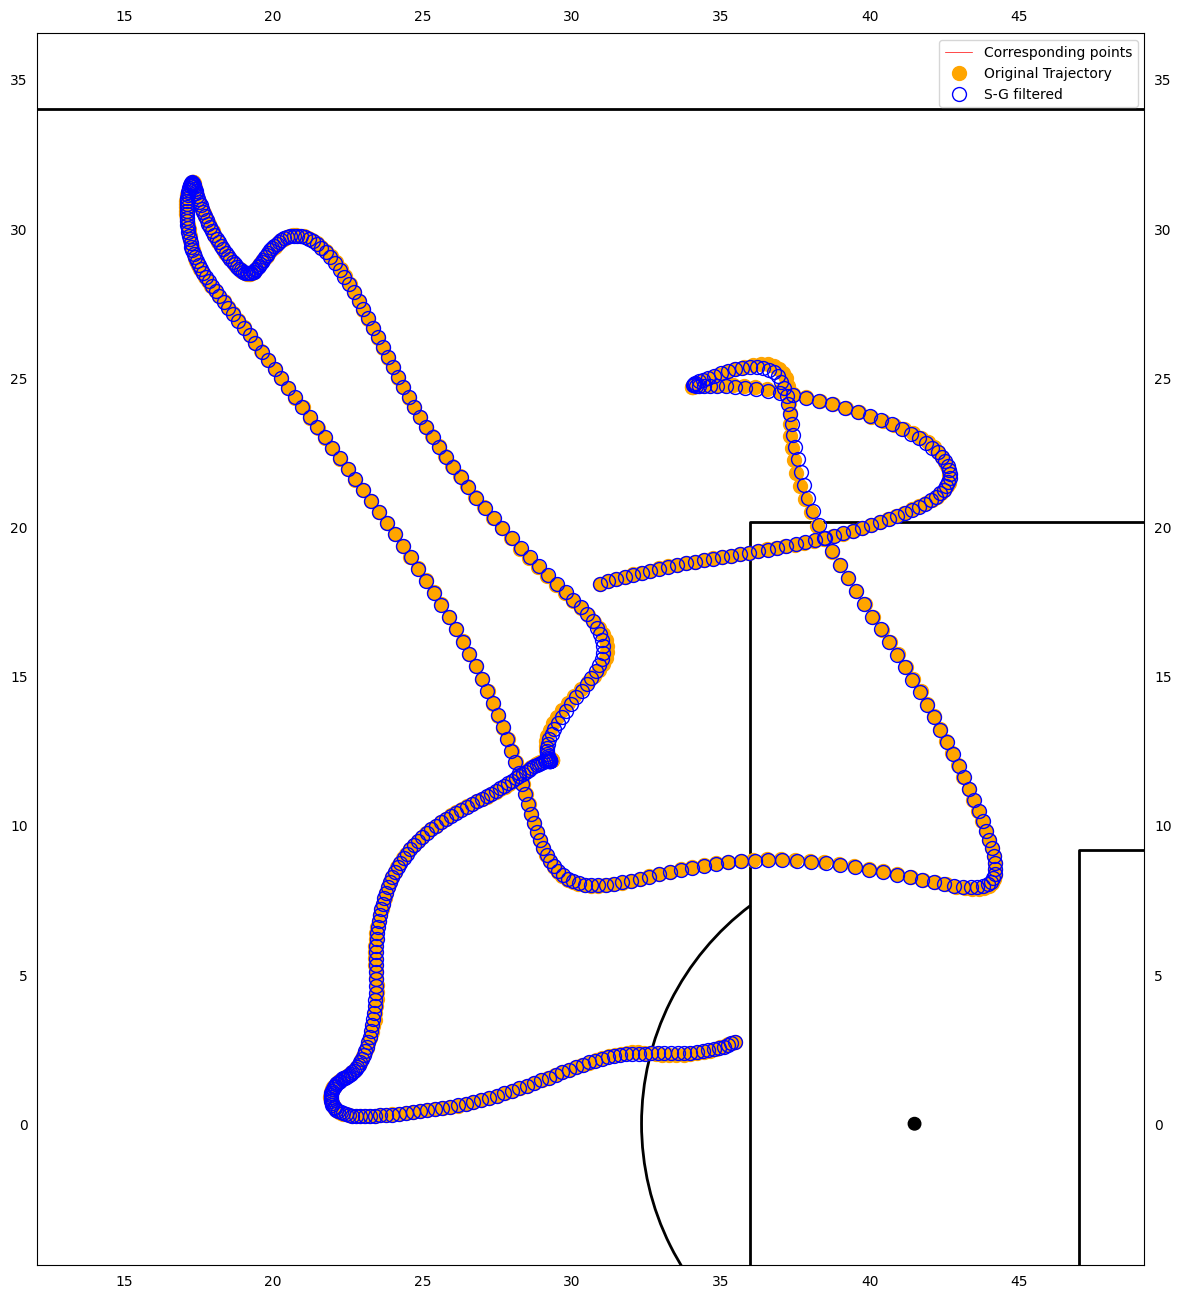

In [ ]:
df1 = smoothIsolatedTrajsDFs[0]
df2 = applySavgol(smoothIsolatedTrajsDFs[0], 5, 2, 1000)
df3 = smoothIsolatedTrajsDFs[-3]
df1['object_id'] = playerID
df2['object_id'] = playerID
df3['object_id'] = playerID

plotMovements(playerID, [df1, df2], start_frame=start_frame, end_frame=end_frame, labels=["Original Trajectory", "S-G filtered"])

In [ ]:
from dtaidistance import dtw_visualisation
dtw_visualisation.plot_warpingpaths(series1, series2, paths, filename="warpNone.png")

(None, None)

<h3>Lock-Step Distance<h3>

In [ ]:
series1 = np.array(traj1, dtype=np.double)
series2 = np.array(traj2, dtype=np.double)

assert(len(series1) == len(series2))
totalDistance = 0
for (x, y) in zip(series1, series2):
    totalDistance += euclidianDistance(x, y)

print(totalDistance)

def getLockStepDistance(DF1, DF2):
    series1 = np.array(DF1[['x', 'y']], dtype=np.double)
    series2 = np.array(DF2[['x', 'y']], dtype=np.double)
    totalDistance = 0
    for (x, y) in zip(series1, series2):
        totalDistance += euclidianDistance(x, y)
    return totalDistance

0.0


<h3>Fréchet Distance</h3>

Using: https://pypi.org/project/frechetdist/

<h3>Acceleration Data from IMU</h3>

In [ ]:
file_path_IMU = '../data/matches/Feb/Leon Avdullahu_IMU_1384039.csv'
partialIMU = read_csv_partially(file_path_IMU, 0, 1500000)

KeyboardInterrupt: 

In [ ]:
def timeStampToFrameID(time_string='01:02:02.960'):
    parts = time_string.split(':')
    hours = int(parts[0])
    minutes = int(parts[1])
    seconds_and_millis = parts[2].split('.')
    seconds = int(seconds_and_millis[0])
    milliseconds = int(seconds_and_millis[1])
    
    # Convert everything to milliseconds
    total_milliseconds = (hours * 3600000) + (minutes * 60000) + (seconds * 1000) + milliseconds
    return total_milliseconds


IMUDF = pd.DataFrame(partialIMU[7:], columns=partialIMU[6])
IMUDF['timestamp'] = IMUDF['Timestamp'].apply(timeStampToFrameID)
IMUDF['object_id'] = playerID
IMUDF['half'] = IMUDF['Period'].apply(lambda x: 1 if x == '1st Half' else 2 if x == '2nd Half' else -1)
firstRow2ndHalf = IMUDF[IMUDF['half'] == 2].iloc[0]
# IMUDF['timestamp'] = IMUDF['timestamp'].apply(lambda x: x - firstRow2ndHalf['timestamp'] if x['half'] == 2 else x)
IMUDF['timestamp'] = IMUDF.apply(lambda row: row['timestamp'] - firstRow2ndHalf['timestamp'] if row['half'] == 2 else row['timestamp'], axis=1)
# IMUDF = IMUDF[IMUDF['half'] != -1]
IMUDF = IMUDF[['half', 'timestamp', 'Timestamp', 'object_id', 'Acceleration.forward', 'Acceleration.side', 'Acceleration.up', 'imuAcceleration.forward', 'imuAcceleration.side', 'Acceleration Magnitude']]
IMUDF['IMU Acceleration Magnitude 2D'] = IMUDF.apply(lambda row: sqrt(float(row['imuAcceleration.forward'])**2 + float(row['imuAcceleration.side'])**2), axis=1)
IMUDF['Acceleration Magnitude'] = IMUDF['Acceleration Magnitude'].astype(float)
IMUDF

,half,timestamp,Timestamp,object_id,Acceleration.forward,Acceleration.side,Acceleration.up,imuAcceleration.forward,imuAcceleration.side,Acceleration Magnitude,IMU Acceleration Magnitude 2D
0,1,0,00:00:00.000,102835,-0.325731992721558,-0.14665199816227,0.963643968105316,-0.0266006886959076,0.0089535117149353,1.027725,0.028067
1,1,10,00:00:00.010,102835,-0.325731992721558,-0.154880002140999,0.96945196390152,-0.0234201699495316,0.00239921361207962,1.034372,0.023543
2,1,20,00:00:00.020,102835,-0.334928005933762,-0.152459993958473,0.972839951515198,-0.0298543125391006,0.00609242171049118,1.040115,0.030470
3,1,30,00:00:00.030,102835,-0.340736001729965,-0.157299995422363,0.972355961799622,-0.0335679650306702,0.00228305906057358,1.042267,0.033646
4,1,40,00:00:00.040,102835,-0.336380004882813,-0.151007995009422,0.967999994754791,-0.0287963598966599,0.00869221985340118,1.035847,0.030080
...,...,...,...,...,...,...,...,...,...,...,...
761796,-1,7617960,02:06:57.960,102835,-0.113255999982357,-0.0774400010704994,0.991715967655182,-0.00305692479014397,0.00446352735161781,1.001162,0.005410
761797,-1,7617970,02:06:57.970,102835,-0.116643995046616,-0.0813120007514954,0.996071994304657,-0.00580716505646706,0.001075379550457,1.006169,0.005906
761798,-1,7617980,02:06:57.980,102835,-0.112287998199463,-0.0798600018024445,0.999459981918335,-0.00121324509382248,0.00273015722632408,1.008914,0.002988
761799,-1,7617990,02:06:57.990,102835,-0.112287998199463,-0.080827996134758,0.994619965553284,-0.00178645923733711,0.00135108456015587,1.004197,0.002240


In [ ]:
print(timeStampToFrameID('00:93:19.900'))

5599900


In [ ]:
smoothened_file_path = f'../data/smoothenedData/{match_id}/smoothened_{match_id}_FULL_10IT.csv'
smoothenedFrames = read_csv_partially(smoothened_file_path, 0, 1500000)

smoothDF = pd.DataFrame(smoothenedFrames[1:], columns=smoothenedFrames[0])
smoothDF = smoothDF[smoothDF['object_id'] == playerID]
smoothDF['timestamp'] = smoothDF['timestamp'].astype(int)
smoothDF['half'] = smoothDF['half'].astype(int)
smoothDF['frame_id'] = smoothDF['frame_id'].astype(int)
smoothDF['speed'] = smoothDF['speed'].apply(lambda x: float(x) if x != '' else None)
smoothDF['arc_length'] = smoothDF['arc_length'].apply(lambda x: float(x) if x != '' else None)
smoothDF['acceleration'] = (smoothDF['speed'].shift(-1) - smoothDF['speed'].shift(1))/((smoothDF['timestamp'].shift(-1) - smoothDF['timestamp'].shift(1))/1000)
# smoothDF['frame_id'] = smoothDF['frame_id'].astype(int)
# smoothDF['object_id'] = smoothDF['object_id'].astype(int)
smoothDF = pd.merge(smoothDF, IMUDF,how='left', on=['timestamp', 'half', 'object_id'])
smoothDF

,match_id,half,frame_id,timestamp,object_id,x,y,z,extrapolated,arc_length,speed,acceleration,Timestamp,Acceleration.forward,Acceleration.side,Acceleration.up,imuAcceleration.forward,imuAcceleration.side,Acceleration Magnitude,IMU Acceleration Magnitude 2D
0,1384039,1,100,0,102835,1.31,-18.49,0.0,True,NaN,NaN,NaN,00:00:00.000,-0.325731992721558,-0.14665199816227,0.963643968105316,-0.0266006886959076,0.0089535117149353,1.027725,0.028067
1,1384039,1,101,100,102835,1.11,-18.45,0.0,True,NaN,NaN,NaN,00:00:00.100,-0.327667981386185,-0.146167993545532,0.999459981918335,0.00268632173538208,0.0249257013201714,1.061909,0.025070
2,1384039,1,102,200,102835,0.91,-18.42,0.0,True,NaN,NaN,NaN,00:00:00.200,-0.375099986791611,-0.0967999994754791,0.964127957820892,-0.0125168263912201,0.0831106677651405,1.039044,0.084048
3,1384039,1,103,300,102835,0.72,-18.38,0.0,True,NaN,NaN,NaN,00:00:00.300,-0.419627994298935,-0.361063987016678,0.9375079870224,0.00535780191421509,-0.140521198511124,1.088750,0.140623
4,1384039,1,104,400,102835,0.54,-18.34,0.0,True,NaN,NaN,NaN,00:00:00.400,-0.451087981462479,-0.46560800075531,0.745844006538391,-0.036708191037178,-0.216258659958839,0.988208,0.219352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30586,1384039,2,40189,998900,102835,25.93,12.94,0.0,True,NaN,NaN,NaN,01:21:48.090,-0.451572000980377,-0.326700001955032,0.814571976661682,-0.0690934360027313,-0.176050126552582,0.987004,0.189123
30587,1384039,2,40190,999000,102835,25.87,13.02,0.0,True,NaN,NaN,NaN,01:21:48.190,-0.371711999177933,-0.24974399805069,0.9375079870224,0.0637707859277725,-0.0635924637317657,1.038972,0.090060
30588,1384039,2,40191,999100,102835,25.8,13.11,0.0,True,NaN,NaN,NaN,01:21:48.290,-0.30443599820137,-0.243935987353325,0.834899961948395,0.0670627132058144,-0.0694624111056328,0.921544,0.096553
30589,1384039,2,40192,999200,102835,25.74,13.19,0.0,True,NaN,NaN,NaN,01:21:48.390,-0.204247996211052,-0.329603999853134,0.730355978012085,0.0967738404870033,-0.160616189241409,0.826907,0.187517


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


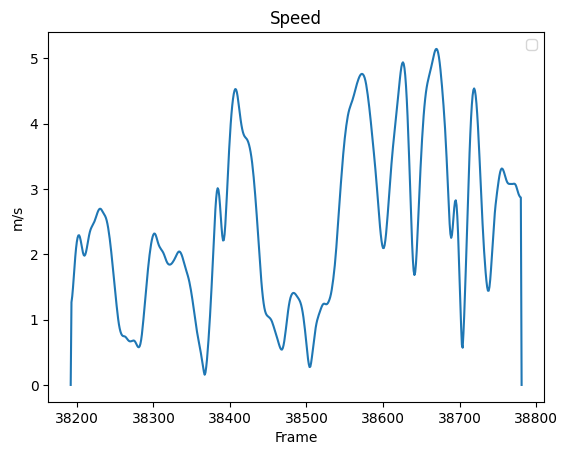

In [ ]:
framePlotDF = smoothDF[(smoothDF['frame_id'] >= start_frame) & (smoothDF['frame_id'] <= end_frame)]
plt.plot(framePlotDF['frame_id'], framePlotDF['speed'])

plt.title('Speed')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s')  # Replace 'Value' with the actual y-axis label
plt.legend()
# plt.xlim(38222, 38335)
plt.show()

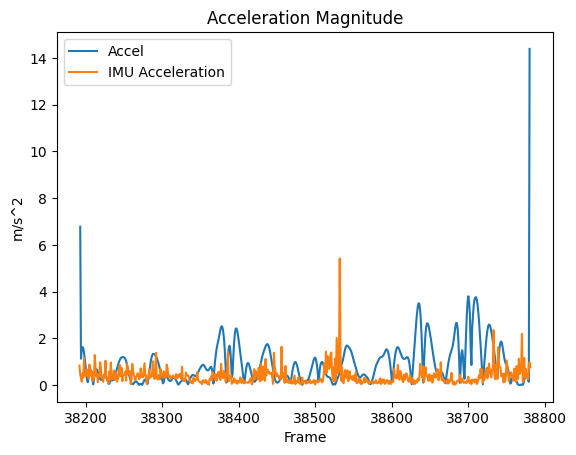

In [ ]:
plt.plot(framePlotDF['frame_id'], framePlotDF['acceleration'].apply(lambda x: abs(x)), label='Accel')
plt.plot(framePlotDF['frame_id'], framePlotDF['IMU Acceleration Magnitude 2D'], label='IMU Acceleration')


plt.title('Acceleration Magnitude')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s^2')  # Replace 'Value' with the actual y-axis label
plt.legend()
# plt.xlim(38222, 38335)
plt.show()

<h2>Noise Experiments</h2>

In [ ]:
def noiseHelper(p1, p, p2, lateralNoise, longitudinalNoise):
    longVec = np.array([p2['x'] - p1['x'], p2['y'] - p1['y']])
    latVec = np.array([-longVec[1], longVec[0]])
    new_p = np.array([p['x'], p['y']])

    alpha = 0
    beta = 0
    
    if(lateralNoise[0] == 'normal'):
        alpha = np.random.normal(lateralNoise[1], lateralNoise[2])
    
    if(longitudinalNoise[0] == 'normal'):
        beta = np.random.normal(longitudinalNoise[1], longitudinalNoise[2])

    new_p = new_p + alpha*latVec + beta*longVec

    return (new_p[0], new_p[1])

In [ ]:
def applyNoise(trajectory, lateralNoiseType, longitudinalNoiseType):
    trajectoryCopy = trajectory.copy()
    for i, row in trajectoryCopy.iterrows():
        if i == 0 or i == len(trajectoryCopy) - 1:
            continue
        trajectoryCopy.loc[i, 'x'], trajectoryCopy.loc[i, 'y'] = noiseHelper(trajectory.loc[i-1], trajectory.loc[i], trajectory.loc[i+1], lateralNoiseType, longitudinalNoiseType)
    
    return trajectoryCopy

In [ ]:
noisyTraj = applyNoise(isolatedTraj.copy(), ['normal', 0, 0.2], ['normal', 0, 0.4])
noisyTraj['object_id'] = playerID
noisyTraj


,x,y,speed,time,frame_id,object_id
0,35.470000,2.740000,0,1970-01-01 01:13:19.200,38192,102835
1,35.293469,2.652466,0,1970-01-01 01:13:19.300,38193,102835
2,35.206526,2.664930,0,1970-01-01 01:13:19.400,38194,102835
3,35.278117,2.654719,0,1970-01-01 01:13:19.500,38195,102835
4,35.123582,2.573768,0,1970-01-01 01:13:19.600,38196,102835
...,...,...,...,...,...,...
585,32.260669,18.607097,0,1970-01-01 01:14:17.700,38777,102835
586,31.657677,18.379191,0,1970-01-01 01:14:17.800,38778,102835
587,31.502465,18.266534,0,1970-01-01 01:14:17.900,38779,102835
588,31.593041,18.073146,0,1970-01-01 01:14:18.000,38780,102835


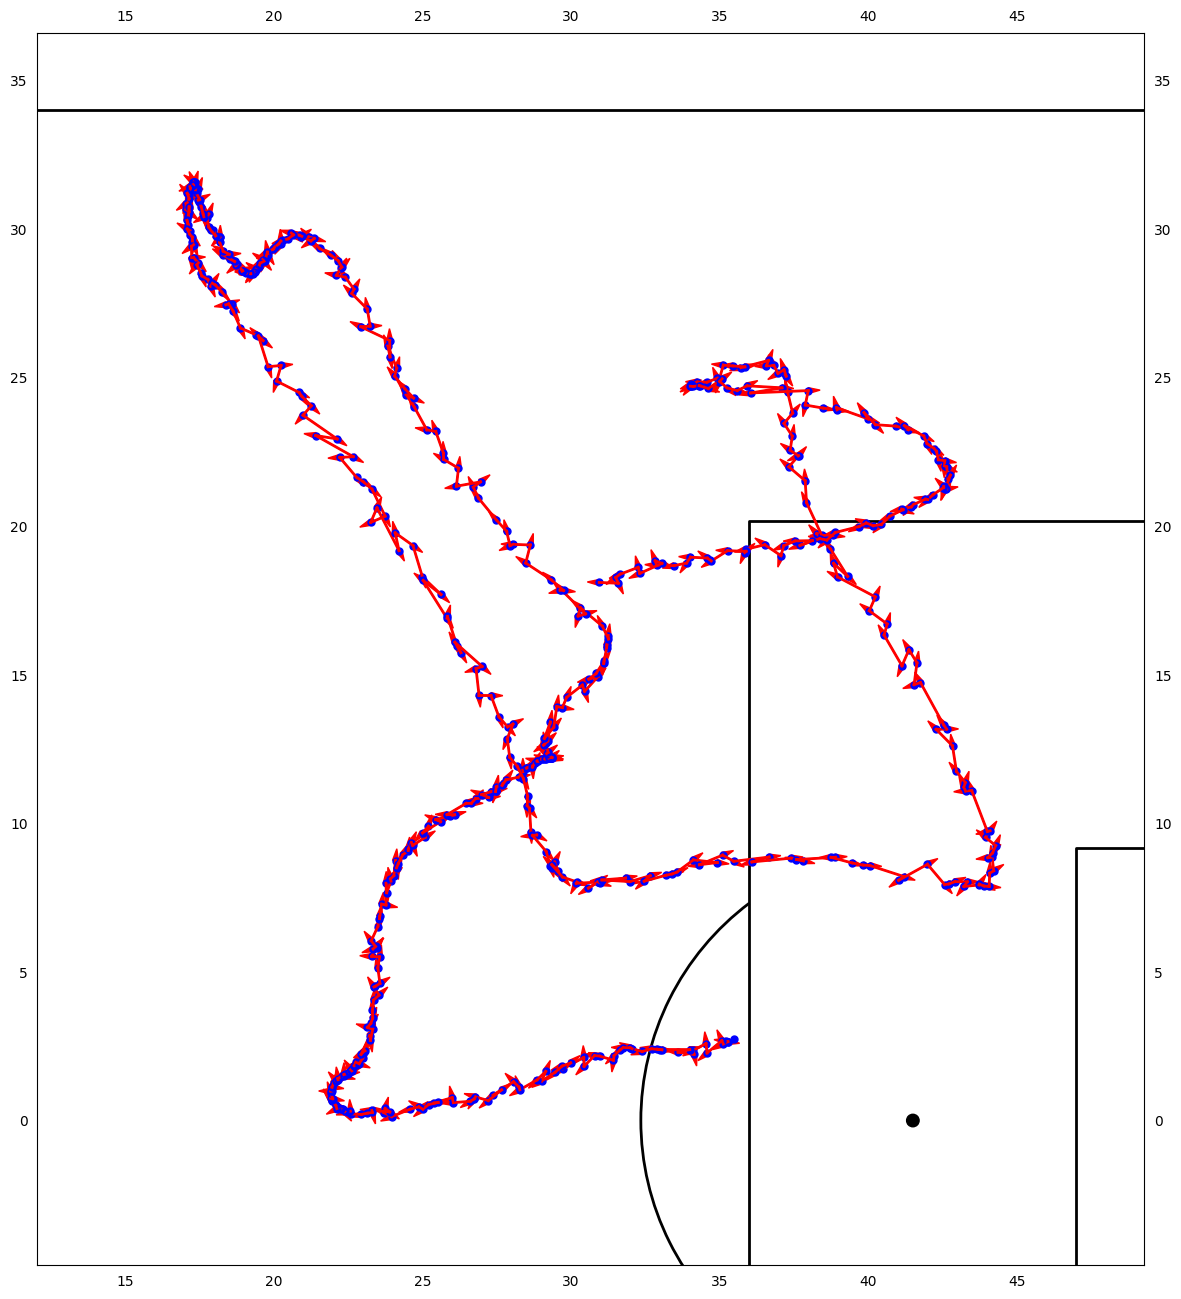

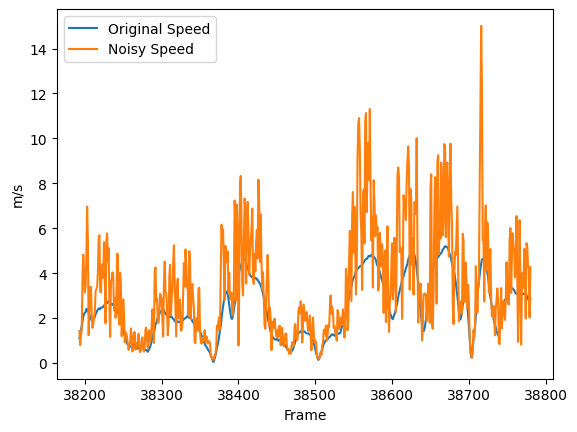

In [ ]:
plotMovement(playerID, noisyTraj, start_frame, end_frame)
# plotMovement(playerID, isolatedTraj, start_frame, end_frame)

# print(f"DTW distance before smoothing {getDTWDistance(isolatedTraj, noisyTraj)}")

plt.plot(isolatedTraj['frame_id'], extractSpeed(isolatedTraj)['speed'], label='Original Speed')
plt.plot(noisyTraj['frame_id'], extractSpeed(noisyTraj)['speed'], label='Noisy Speed')
plt.xlabel('Frame')
plt.ylabel('m/s')
plt.legend()
plt.show()


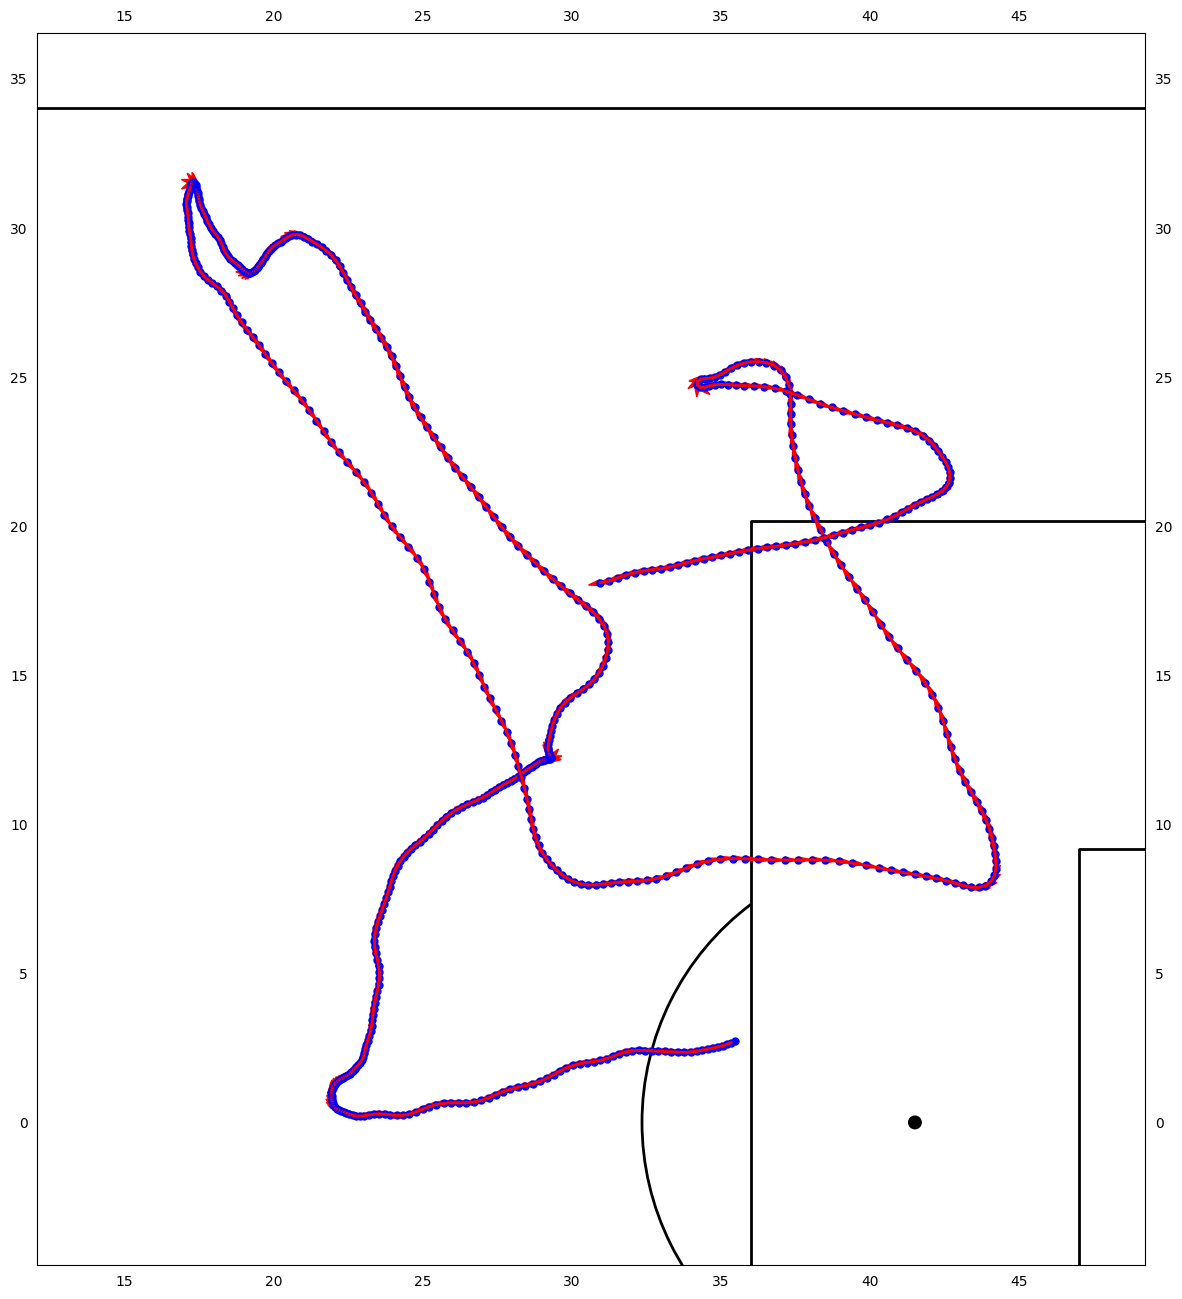

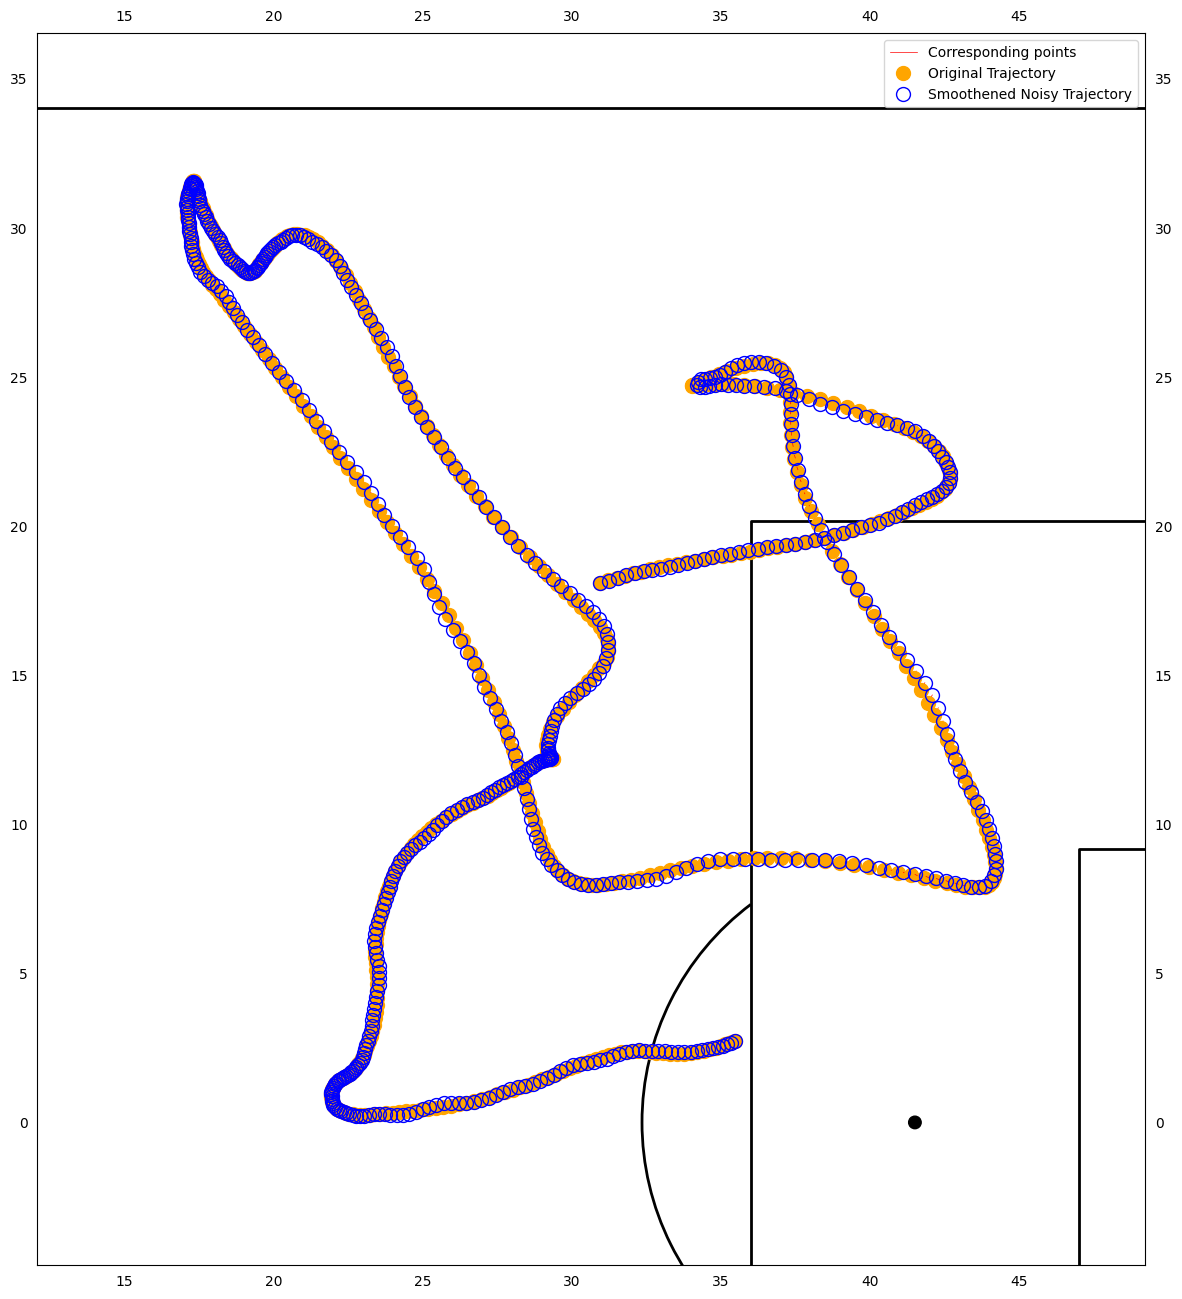

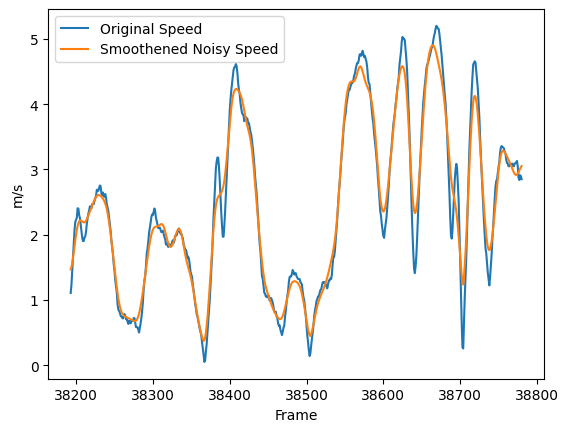

In [ ]:
smoothNoisy = pd.DataFrame(performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 50))
smoothNoisy.columns = ['x', 'y', 'arclength', 'time', 'frame_id']
smoothNoisy['speed'] = smoothNoisy['arclength']*10
smoothNoisy['object_id'] = playerID
smoothNoisy['frame_id'] = noisyTraj['frame_id']
plotMovement(playerID, smoothNoisy, start_frame, end_frame)
# print(f"Trajectory similarity after smoothing {getDTWDistance(isolatedTraj, smoothNoisy)}")
plotMovements(playerID, [isolatedTraj, smoothNoisy], start_frame, end_frame, labels=['Original Trajectory', 'Smoothened Noisy Trajectory'])

plt.plot(isolatedTraj['frame_id'], extractSpeed(isolatedTraj)['speed'], label='Original Speed')
plt.plot(noisyTraj['frame_id'], smoothNoisy['speed'], label='Smoothened Noisy Speed')
plt.xlabel('Frame')
plt.ylabel('m/s')
plt.legend()
plt.show()


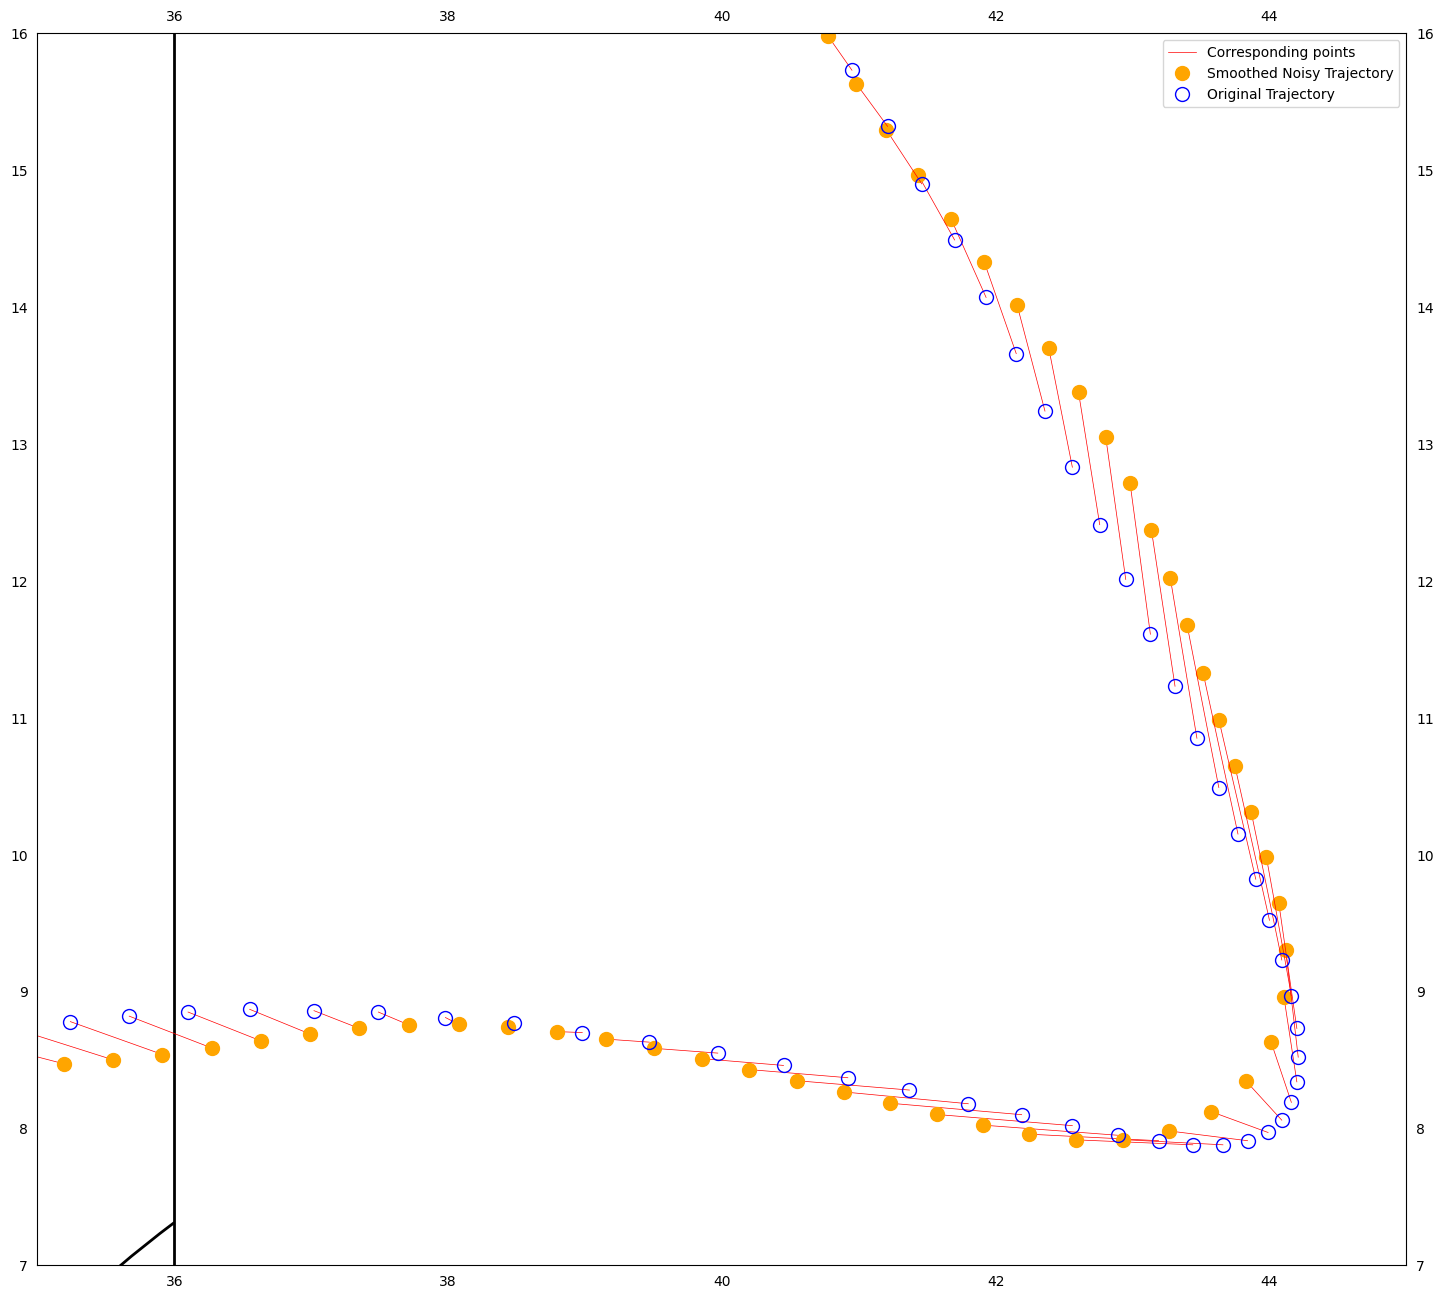

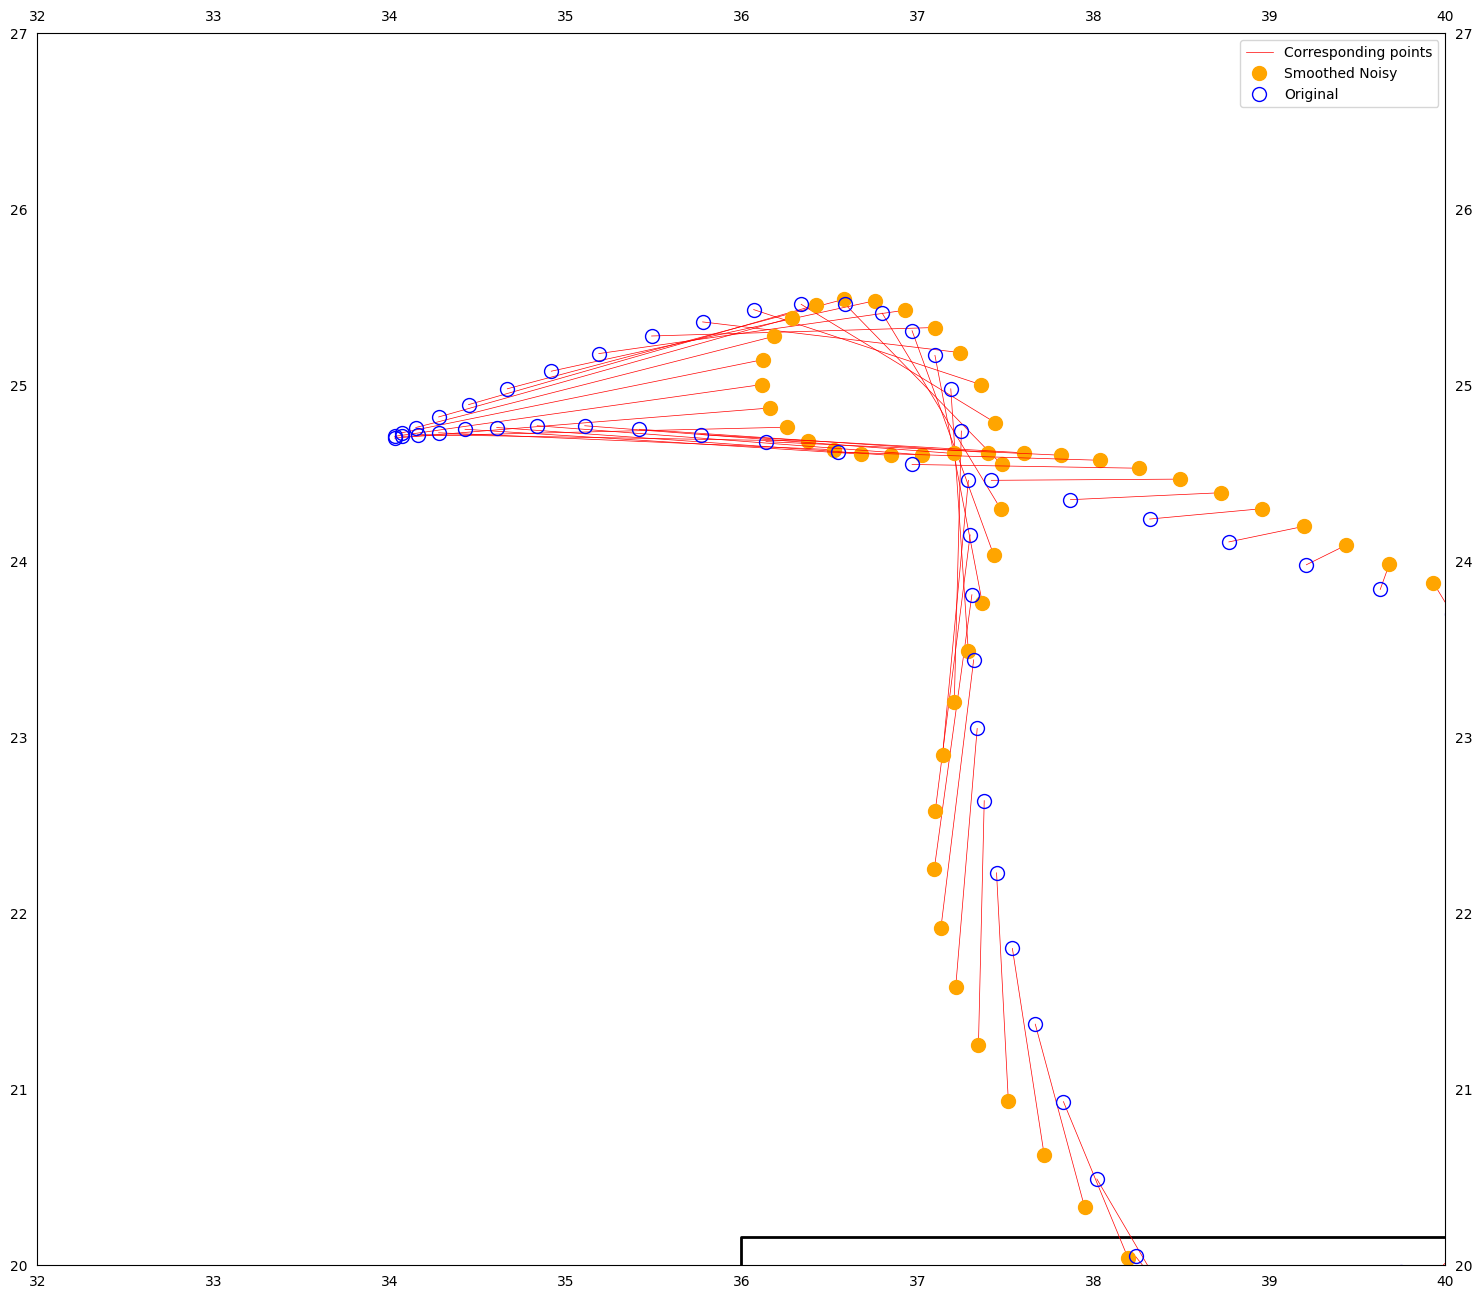

In [ ]:
plotMovements(playerID, [smoothNoisy, isolatedTraj], start_frame, end_frame, labels=['Smoothed Noisy Trajectory', 'Original Trajectory'], windowp=[35, 45, 7, 16])
plotMovements(playerID, [smoothNoisy, isolatedTraj], start_frame, end_frame, labels=['Smoothed Noisy', 'Original'], windowp=[32, 40, 20, 27])
# plotMovements(playerID, [smoothNoisy, isolatedTraj], start_frame, end_frame, labels=['Smoothed Noisy Trajectory', 'Original Trajectory'])



In [ ]:
def reformatDF(df):
    df.columns = ['x', 'y', 'speed', 'time', 'frame_id']
    df['frame_id'] = isolatedTraj['frame_id']
    df['object_id'] = playerID
    return df

In [ ]:
smoothNoisyDFs = [
    # performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 1),
    # performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 2),
    # performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 4),
    # performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 10),
    performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 50),
    # performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 100),
    # performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 200),
    # performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 400),
    # performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 600),
    # performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 800),
    # performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 2000),
]

smoothDFs = [
    # performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 1),
    # performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 2),
    # performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 4),
    # performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 10),
    performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 50),
    # performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 100),
    # performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 200),
    # performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 400),
    # performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 2000),
]
its = [
    # 1, 2, 4, 10,
    50,
    # 100, 200, 400,
        # 200, 400, 600, 800, 1000
    ]

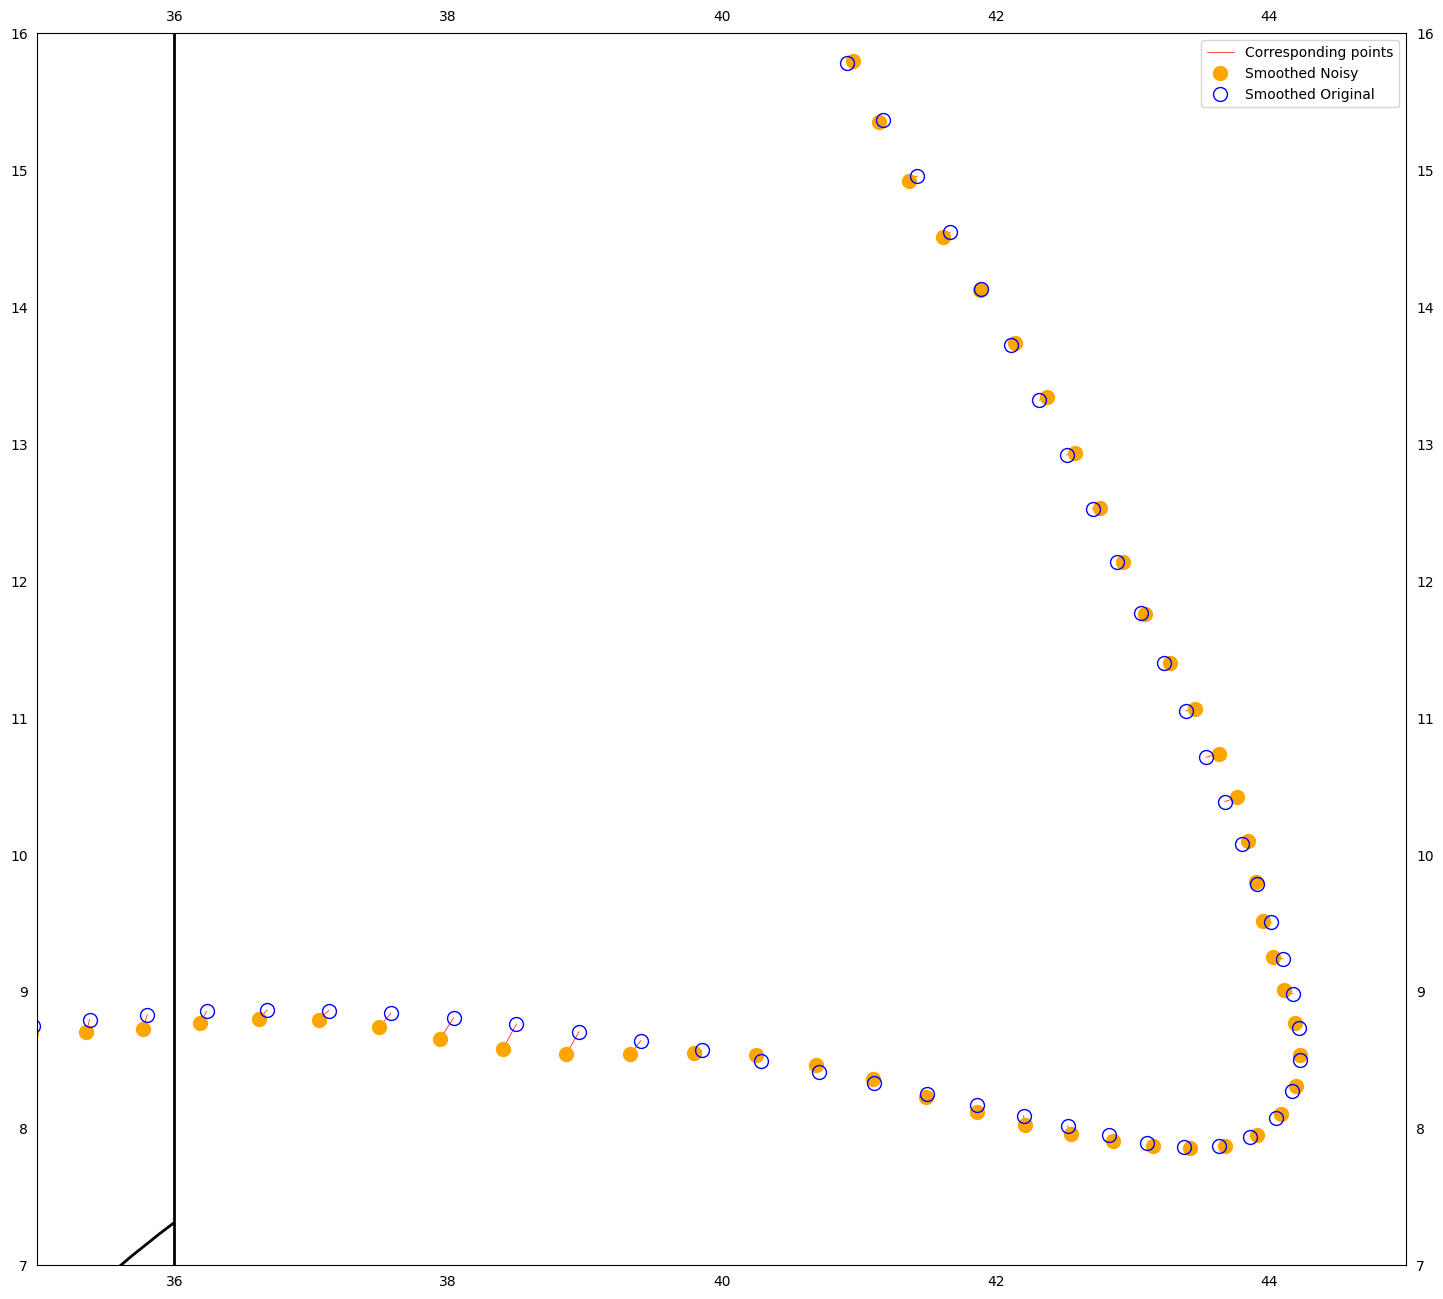

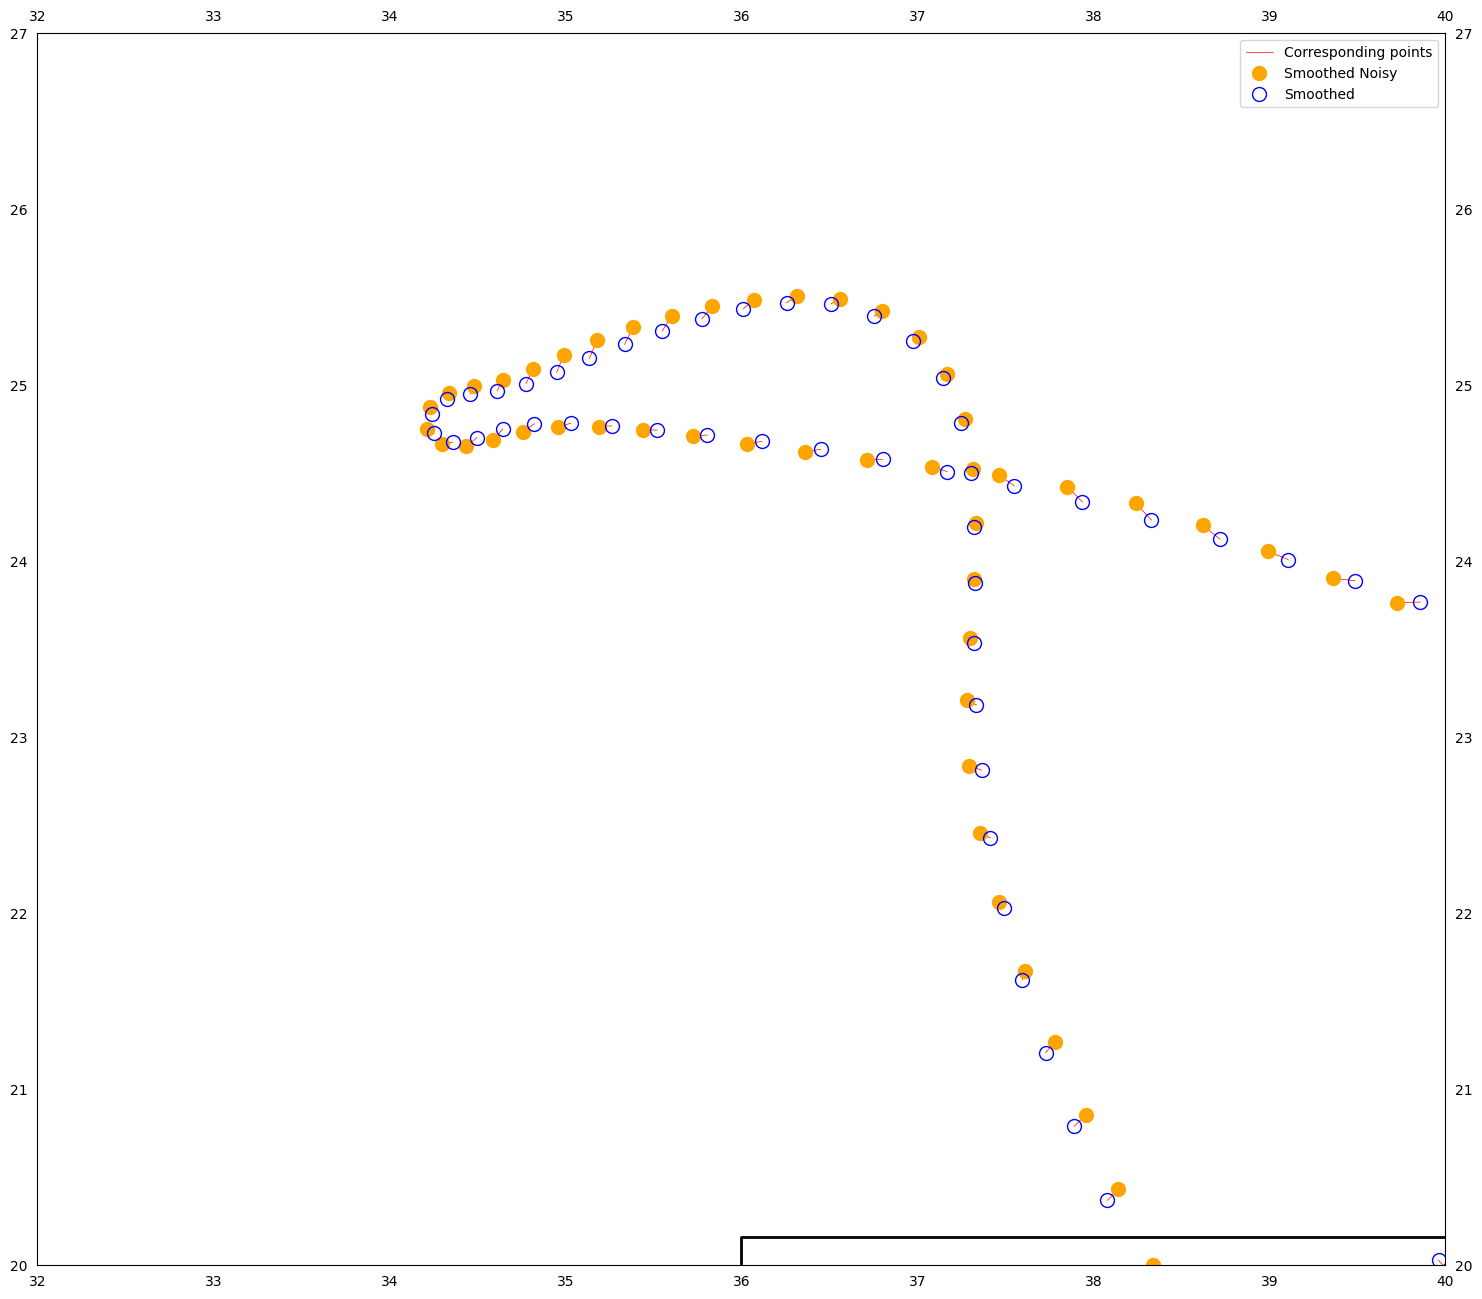

In [ ]:
plotMovements(playerID, [reformatDF(pd.DataFrame(smoothNoisyDFs[0])), reformatDF(pd.DataFrame(smoothDFs[0]))], start_frame, end_frame, labels=['Smoothed Noisy', 'Smoothed Original'], 
               windowp=[35, 45, 7, 16])

plotMovements(playerID, [reformatDF(pd.DataFrame(smoothNoisyDFs[0])), reformatDF(pd.DataFrame(smoothDFs[0]))], start_frame, end_frame, labels=['Smoothed Noisy', 'Smoothed'], 
               windowp=[32, 40, 20, 27])
# plotMovements(playerID, [reformatDF(isoDF), reformatDF(pd.DataFrame(smoothDFs[-3]))], start_frame, end_frame, labels=['Original', 'Smooth'])


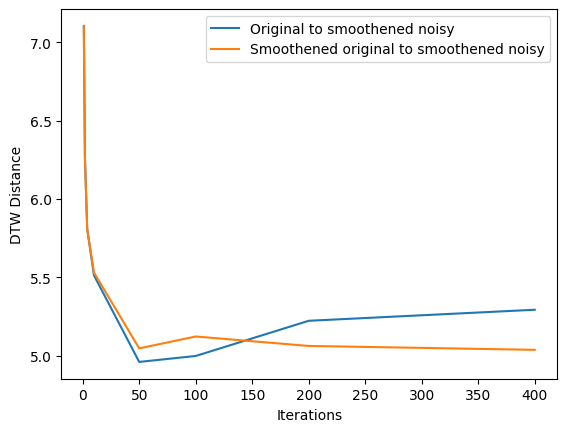

In [ ]:
plt.plot(its[:8], list(map(lambda x: getDTWDistance(isolatedTraj, reformatDF(pd.DataFrame(x))), smoothNoisyDFs))[:8], label='Original to smoothened noisy')
plt.plot(its[:8], list(map(lambda x: getDTWDistance(reformatDF(pd.DataFrame(x[1])), reformatDF(pd.DataFrame(smoothNoisyDFs[x[0]]))), enumerate(smoothDFs)))[:8], label='Smoothened original to smoothened noisy')
# plt.title('Similarity of smoothened noisy trajectory to original trajectory for different amounts of iterations')
plt.xlabel('Iterations')  # Replace 'Index' with the actual x-axis label
plt.ylabel('DTW Distance')  # Replace 'Value' with the actual y-axis label  
plt.legend()
plt.show()

Conclusion from DTW plot: 
- We can see that the distance to the original trajectory is minimal at around 10 iterations, which is quite unexpected, since visually it seems that around 100 iterations is better at completely removing the noise
- As expected, when smoothing both the noisy and original trajectory they converge slowly to a similar trajectory

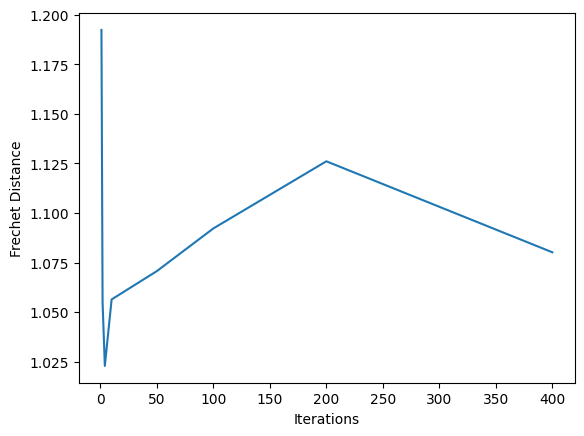

In [ ]:
plt.plot(its[:8], list(map(lambda x: getFrechetDistance(isolatedTraj, reformatDF(pd.DataFrame(x))), smoothNoisyDFs[:8])))
# plt.title('Similarity of smoothened noisy trajectory to original trajectory for different amounts of iterations')
plt.xlabel('Iterations')  # Replace 'Index' with the actual x-axis label
plt.ylabel('Frechet Distance')  # Replace 'Value' with the actual y-axis label  
plt.show()

Interesting, inspect frechet distance computation. What happens between 100 and 200?

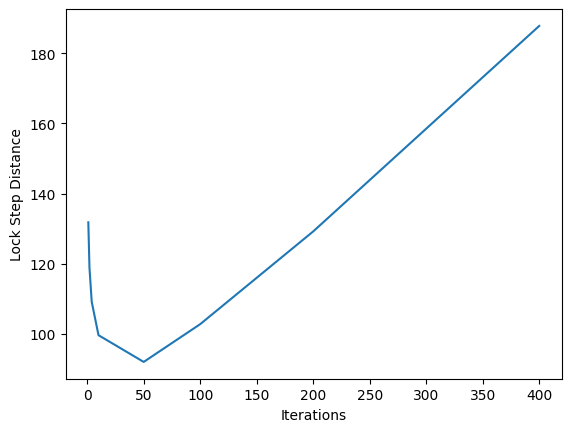

In [ ]:
plt.plot(its[:8], list(map(lambda x: getLockStepDistance(isolatedTraj, reformatDF(pd.DataFrame(x))), smoothNoisyDFs[:8])))
# plt.title('Similarity of smoothened noisy trajectory to original trajectory for different amounts of iterations')
plt.xlabel('Iterations')  # Replace 'Index' with the actual x-axis label
plt.ylabel('Lock Step Distance')  # Replace 'Value' with the actual y-axis label  
plt.show()